# Data Understanding and Preprocessing

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .master("local") \
    .appName("Data Understanding and Preprocessing") \
    .getOrCreate()

data = spark.read.csv("data.csv", header=True, sep=',',inferSchema="true")
print(data.dtypes)
data.printSchema()

[('Id', 'string'), ('groupId', 'string'), ('matchId', 'string'), ('assists', 'int'), ('boosts', 'int'), ('damageDealt', 'double'), ('DBNOs', 'int'), ('headshotKills', 'int'), ('heals', 'int'), ('killPlace', 'int'), ('killPoints', 'int'), ('kills', 'int'), ('killStreaks', 'int'), ('longestKill', 'double'), ('matchDuration', 'int'), ('matchType', 'string'), ('maxPlace', 'int'), ('numGroups', 'int'), ('rankPoints', 'int'), ('revives', 'int'), ('rideDistance', 'double'), ('roadKills', 'int'), ('swimDistance', 'double'), ('teamKills', 'int'), ('vehicleDestroys', 'int'), ('walkDistance', 'double'), ('weaponsAcquired', 'int'), ('winPoints', 'int'), ('winPlacePerc', 'double')]
root
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: integer (nullable = true)

In [2]:
from pyspark.sql import SQLContext

sqlCtx = SQLContext(spark)
data.createOrReplaceTempView("pubg")

## Missing values


In [3]:
for col in data.columns:
    tmp = sqlCtx.sql("SELECT "+col+", COUNT(*) as missingValues FROM pubg WHERE "+col+" IS NULL GROUP BY "+ col)
    tmp.show()

+---+-------------+
| Id|missingValues|
+---+-------------+
+---+-------------+

+-------+-------------+
|groupId|missingValues|
+-------+-------------+
+-------+-------------+

+-------+-------------+
|matchId|missingValues|
+-------+-------------+
+-------+-------------+

+-------+-------------+
|assists|missingValues|
+-------+-------------+
+-------+-------------+

+------+-------------+
|boosts|missingValues|
+------+-------------+
+------+-------------+

+-----------+-------------+
|damageDealt|missingValues|
+-----------+-------------+
+-----------+-------------+

+-----+-------------+
|DBNOs|missingValues|
+-----+-------------+
+-----+-------------+

+-------------+-------------+
|headshotKills|missingValues|
+-------------+-------------+
+-------------+-------------+

+-----+-------------+
|heals|missingValues|
+-----+-------------+
+-----+-------------+

+---------+-------------+
|killPlace|missingValues|
+---------+-------------+
+---------+-------------+

+----------+------

Un solo missing values in winPlacePerc --> si droppa

In [4]:
data = data.filter(data.winPlacePerc.isNotNull())
data.createOrReplaceTempView("pubg")

In [5]:
tmp = sqlCtx.sql("SELECT winPlacePerc, COUNT(*) as missingValues FROM pubg WHERE winPlacePerc IS NULL GROUP BY winPlacePerc")
tmp.show()

+------------+-------------+
|winPlacePerc|missingValues|
+------------+-------------+
+------------+-------------+



### Distribuzione percentuali (winPlacePerc) in un singolo match

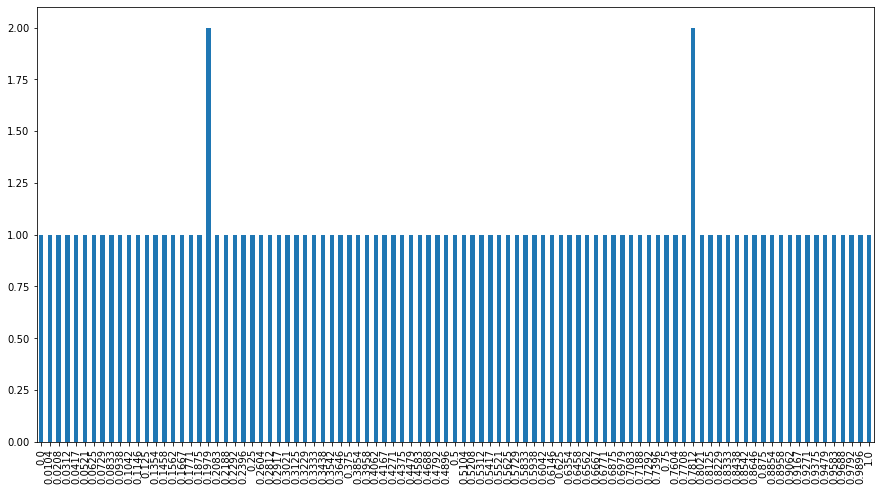

In [6]:
#lista = data.where(data.numGroups == 25).rdd.map(lambda x: x["winPlacePerc"]).collect()
lista = data.where(data.matchId == '6dc8ff871e21e6').rdd.map(lambda x: x["winPlacePerc"]).collect()

tmp = pd.DataFrame()
lista.sort()
plt.figure(figsize=(15,8))
tmp["0"] = lista
tmp["0"].value_counts().sort_index().plot(kind="bar")

In [7]:
for i, el in enumerate(lista[0:-1]):
    print(lista[i]-lista[i+1])

-0.0104
-0.0104
-0.0104
-0.010500000000000002
-0.0104
-0.0104
-0.010400000000000006
-0.010399999999999993
-0.010499999999999995
-0.010400000000000006
-0.010399999999999993
-0.010400000000000006
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.010499999999999982
-0.01040000000000002
-0.010399999999999993
-0.010399999999999993
0.0
-0.01040000000000002
-0.010499999999999982
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.01040000000000002
-0.020799999999999985
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.010399999999999965
-0.010400000000000076
-0.0103

In [8]:
len(lista)

97

In [9]:
# Seleziono i duplicati, usabile solo per match da 1 persona
sqlCtx.sql("""SELECT p1.*
                    from pubg p1, pubg p2
                    where p1.matchid = '6dc8ff871e21e6' 
                        and p1.groupid = p2.groupid
                        and p1.id <> p2.id
                    order by winPlacePerc""").show(100)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+
|cf806bed1e2faa|005

osservazioni sul matchid 6dc8ff871e21e6
Questo match è composto da squadre di una persona.
Se osserviamo il plot (score X #persone) vediamo come ci sono alcuni punteggi assegnati a due persone, il che è possibile solo in caso di pareggio. Nello specifico ci sono 4 persone con lo stesso punteggio (=> 2 non dovrebbero esistere)
La lista di giocatori di tale match risulta essere compsta da 97 elementi, tuttavia, l'attributo numGroups ha valore 95 (che torna con i 2 valori anomali).

I due utenti duplicati hanno come id rispettivamente f921a757de248b e cf806bed1e2faa, tuttavia hanno lo stesso groupid. potrebbe essere causato da una perdita di connessione (rientra in partita dopo un crash)

Alcuni attributi di un player tra quei due di prima risultano a 0 (distance, weaponsAcquired, damageDealt). 
- Serve unificare i record
- Conviene eliminare uno dei due duplicati (ad esempio quello con distance==0)? NON FATTIBILE --> non è sempre vero (vedi groupid 8f7560b8e2a612)

Altre ipotesi:
- numGroups indica il numero di gruppi (distinct groupid) nel match
- maxPlace indica il numero di giocatori (distinct playerid) nel match
- La classifica contiene due giocatori con lo stesso punteggio --> sono quelli crashati e riconnessi che hanno id diverso, ma stesso gruppo. 
- Guardando le distanze tra un winplaceperc e il suo successore otteniamo la maggior parte delle volte un valore costante (.0104...), ma non sempre (alcune volte è il doppio: .0208). Penso quindi che i percentili generati siano nello stesso numero di maxPlace. Per tenere di conto del problema delle disconnessioni dovremmo quindi trasformare la percentuale nella posizione effettiva della classifica e ricalcolare i percentili calcolandoli sull'attributo maxPlace


Date queste osservazioni vedo sempre più necessario il fatto di trattare i dati aggregandoli per gruppi così da poter fare un unico modello e, contemporanemente, risolvere il problema delle riconnessioni (anche perchè nel caso del giocatore singolo sei in grado di capire a che giocatore associare i dati aggregati)

In [9]:
def histogram(column, bins=10, ylabel='frequency'):
    rdd = spark.sql(f'SELECT {column} FROM pubg').rdd.map(lambda x: x[0])
    hist = rdd.histogram(bins)
    df = pd.DataFrame(list(zip(*hist)), columns=[column, 'frequency'])
    df[column] = df[column].apply(lambda x: f'{x:.2f}')
    print(df.head(10))
    # display
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x = column, y = 'frequency', data = df, color='#3776ab')
    ax.set(xlabel=column, ylabel=ylabel)
    ax.tick_params(axis='x', rotation=90)
    plt.title(column)
    plt.show()

## Discretizzazione target (winPlacePerc)
the target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [8]:
tmp = sqlCtx.sql("SELECT count(distinct(winPlacePerc)) FROM pubg").show()

+----------------------------+
|count(DISTINCT winPlacePerc)|
+----------------------------+
|                        3000|
+----------------------------+



In [6]:
from pyspark.sql.functions import col

In [7]:
data.select('winPlacePerc').summary().show()

+-------+-------------------+
|summary|       winPlacePerc|
+-------+-------------------+
|  count|            4446965|
|   mean|0.47282155272193915|
| stddev| 0.3074049817000346|
|    min|                0.0|
|    25%|                0.2|
|    50%|             0.4583|
|    75%|             0.7407|
|    max|                1.0|
+-------+-------------------+



  winPlacePerc  frequency
0         0.00     621846
1         0.10     485258
2         0.20     461998
3         0.30     410339
4         0.40     385639
5         0.50     423227
6         0.60     376146
7         0.70     385841
8         0.80     427440
9         0.90     469231


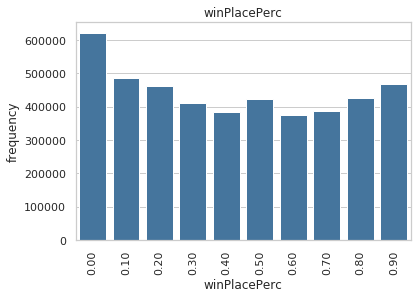

In [10]:
histogram('winPlacePerc')

In [11]:
from pyspark.sql.functions import col
data = data.withColumn('winPlaceClass', when(col("winPlacePerc") == 0, 6)
                                .when(col("winPlacePerc") == 1,  1)
                                .when( (col("winPlacePerc") > 0) & (col("winPlacePerc") <= 0.25 ), 5)
                                .when( (col("winPlacePerc") > 0.25) & (col("winPlacePerc") <= 0.5 ), 4)
                                .when( (col("winPlacePerc") > 0.5) & (col("winPlacePerc") <= 0.75 ), 3)
                                .when( (col("winPlacePerc") > 0.75) & (col("winPlacePerc") < 1 ), 2)
               )

data.createOrReplaceTempView("pubg")

In [12]:
tmp = sqlCtx.sql("SELECT winPlaceClass, COUNT(distinct groupid) as countGroup, COUNT(*) as count FROM pubg GROUP BY winPlaceClass")
tmp.show()
df = tmp.toPandas().set_index("winPlaceClass")

+-------------+----------+-------+
|winPlaceClass|countGroup|  count|
+-------------+----------+-------+
|            1|     47890| 127573|
|            6|     47964| 220505|
|            3|    474616| 959864|
|            5|    482984|1133462|
|            4|    499435|1066178|
|            2|    473855| 939383|
+-------------+----------+-------+



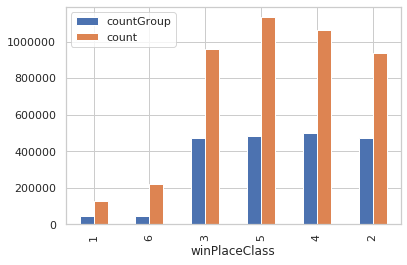

In [13]:
tmp.toPandas().set_index("winPlaceClass").plot.bar()

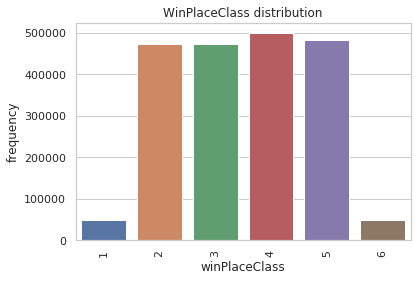

In [14]:
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = df.index, y = 'countGroup',  data = df)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='frequency')
plt.title("WinPlaceClass distribution")
plt.savefig('WinPlaceClassDistr.pdf', bbox_inches='tight')
plt.show()

## matchType
string identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
Scegliamo di diminuire le modalità di gioco eliminando quelle che contengono pochi record (<10k) in questo modo otteniamo le combinazioni di prima o terza persona per solo, duo, sq4.

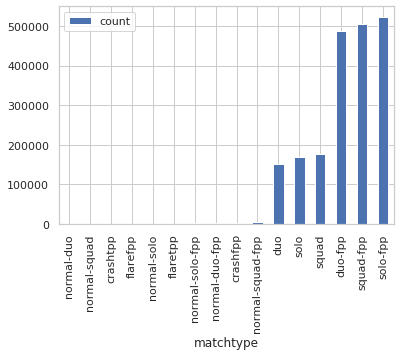

In [15]:
tmp1 = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp1.toPandas().set_index("matchtype").plot(kind="bar")

In [16]:
toKeep = tmp1.rdd.filter(lambda x: x[1] > 10000).map(lambda x: x["matchtype"]).collect()

In [17]:
toKeep

['duo', 'solo', 'squad', 'duo-fpp', 'squad-fpp', 'solo-fpp']

In [18]:
data = data.filter(data.matchType.isin(toKeep))
data.createOrReplaceTempView("pubg")

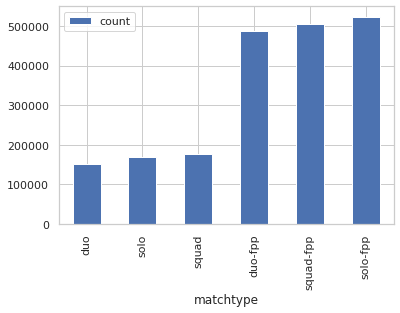

In [19]:
tmp2 = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp2.toPandas().set_index("matchtype").plot(kind="bar")

Nuova colonna "isFistPerson" per indicare se il match è in modalità prima persona o meno

In [20]:
data = data.withColumn("isFirstPerson", when(col("matchtype").contains("fpp"), True).otherwise(False))

Si raggruppano i tipi di match in 3 categorie: solo, duo e squad

In [21]:
data = data.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

data.createOrReplaceTempView("pubg")

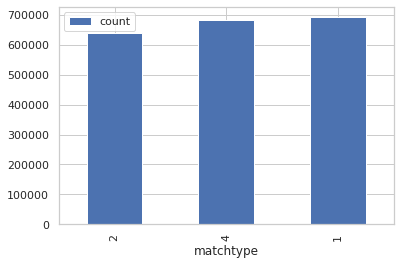

In [22]:
tmp3 = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp3.toPandas().set_index("matchtype").plot(kind="bar")

In [23]:
tmp3.show()

+---------+------+
|matchtype| count|
+---------+------+
|        2|638815|
|        4|683241|
|        1|692034|
+---------+------+



In [24]:
tmp4 = sqlCtx.sql("""SELECT isFirstPerson, count(distinct groupId) as count FROM pubg GROUP BY isFirstPerson ORDER BY count(distinct groupId)""")
tmp4.show()

+-------------+-------+
|isFirstPerson|  count|
+-------------+-------+
|        false| 497981|
|         true|1516109|
+-------------+-------+



In [25]:
place_match = sqlCtx.sql("""SELECT winPlaceClass, matchtype, COUNT(distinct groupid) as countGroup, COUNT(*) as count FROM pubg GROUP BY winPlaceClass, matchtype ORDER BY count(distinct groupId)""")
place_match.show()

+-------------+---------+----------+------+
|winPlaceClass|matchtype|countGroup| count|
+-------------+---------+----------+------+
|            1|        1|      7907|  8468|
|            6|        1|      7975| 21823|
|            1|        2|     13975| 27691|
|            6|        2|     13976| 46196|
|            1|        4|     25233| 88762|
|            6|        4|     25234|149532|
|            3|        2|    148327|295391|
|            2|        2|    150545|294483|
|            2|        4|    153081|470016|
|            5|        2|    153361|321960|
|            5|        4|    157402|630363|
|            3|        4|    157906|488189|
|            4|        2|    158631|324561|
|            4|        4|    164385|555850|
|            3|        1|    165448|168516|
|            2|        1|    167607|168172|
|            5|        1|    169653|174022|
|            4|        1|    173444|177703|
+-------------+---------+----------+------+



<Figure size 432x288 with 0 Axes>

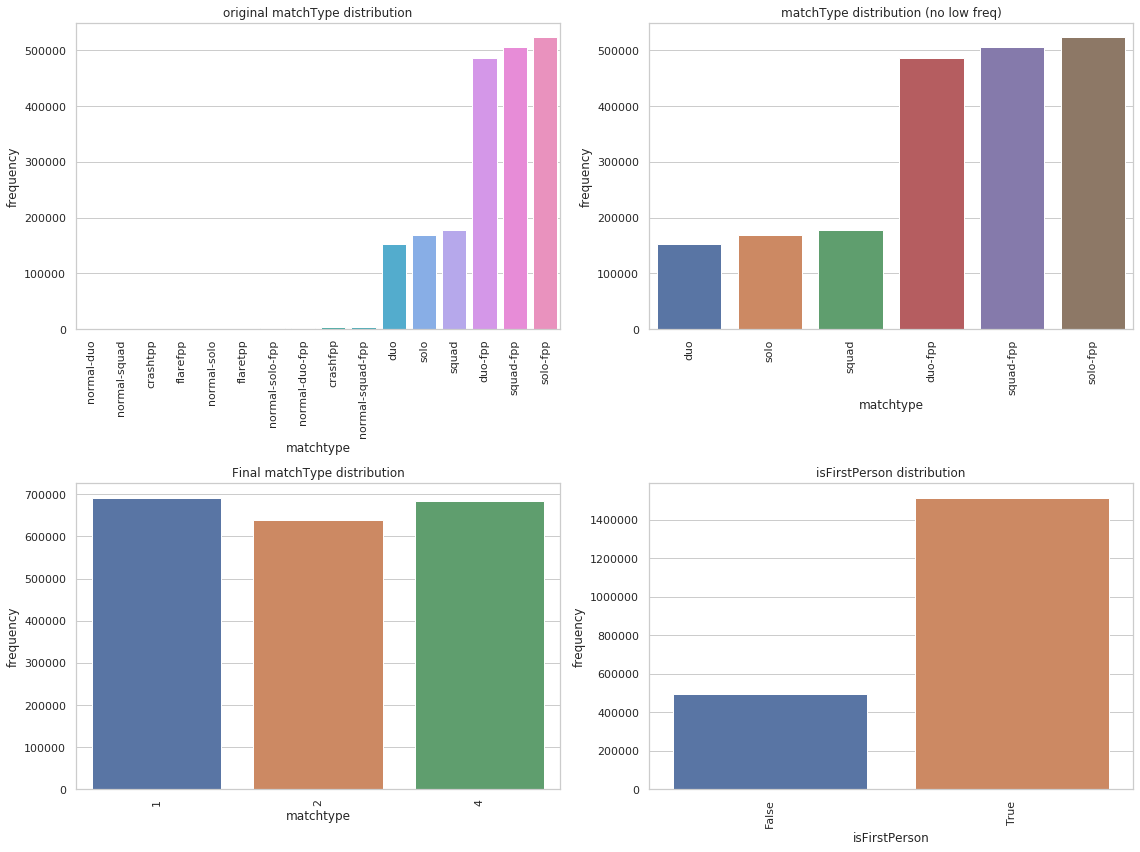

In [58]:
df1 = tmp1.toPandas()
df2 = tmp2.toPandas()
df3 = tmp3.toPandas()
df4 = tmp4.toPandas()

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(16,12))

plt.subplot(2,2,1)
ax = sns.barplot(x = 'matchtype', y = 'count',  data = df1)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='frequency')
plt.title("original matchType distribution")

plt.subplot(2,2,2)
ax = sns.barplot(x = 'matchtype', y = 'count',  data = df2)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='frequency')
plt.title("matchType distribution (no low freq)")

plt.subplot(2,2,3)
ax = sns.barplot(x = 'matchtype', y = 'count',  data = df3)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='frequency')
plt.title("Final matchType distribution")

plt.subplot(2,2,4)
ax = sns.barplot(x = 'isFirstPerson', y = 'count',  data = df4)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='frequency')
plt.title("isFirstPerson distribution")

fig.tight_layout()
fig.savefig('matchtype.pdf', bbox_inches='tight')
plt.show()

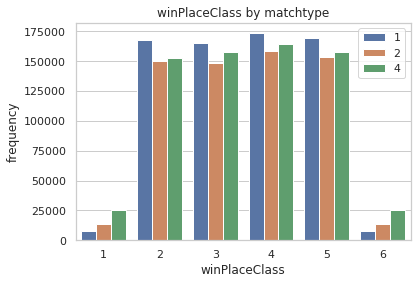

In [61]:
df = place_match.toPandas()

# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(x ="winPlaceClass", y = 'countGroup', data = df, hue='matchtype')
ax.set(ylabel='frequency')
plt.title("winPlaceClass by matchtype")
plt.legend(loc='upper right')
plt.savefig('matchtype_winplaceclass.pdf', bbox_inches='tight')
plt.show()

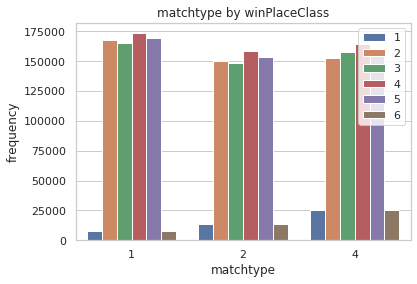

In [62]:
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(x ="matchtype", y = 'countGroup', data = df, hue='winPlaceClass')
ax.set(ylabel='frequency')
plt.title("matchtype by winPlaceClass")
plt.legend(loc='upper right')
plt.savefig('winplaceclass_matchtype.pdf', bbox_inches='tight')
plt.show()

## Identificatori: Id, groupId, matchId

Id: unique identifier of a single player, which can partecipate or not in a team.

groupId: ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

matchID: ID to identify match.

In [34]:
F'Record totali: {data.count()}'

'Record totali: 4411698'

In [35]:
sqlCtx.sql("""SELECT count(Id) FROM pubg""").show()
sqlCtx.sql("""SELECT count(distinct groupId) FROM pubg""").show()
sqlCtx.sql("""SELECT count(distinct matchId) FROM pubg""").show()

+---------+
|count(Id)|
+---------+
|  4411698|
+---------+

+-----------------------+
|count(DISTINCT groupId)|
+-----------------------+
|                2014090|
+-----------------------+

+-----------------------+
|count(DISTINCT matchId)|
+-----------------------+
|                  47185|
+-----------------------+



## assist

the assists means that i don't kill enemy but help kill enemy. So when you look at the variable, there is also a kill. In other words, if I kill the enemy? kill +1. but if I did not kill the enemy but helped kill the enemy?assists + 1

In [18]:
data.select('assists').summary().show()

+-------+-------------------+
|summary|            assists|
+-------+-------------------+
|  count|            4411698|
|   mean|0.22876361890591787|
| stddev| 0.5704108734878232|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  0|
|    max|                 12|
+-------+-------------------+



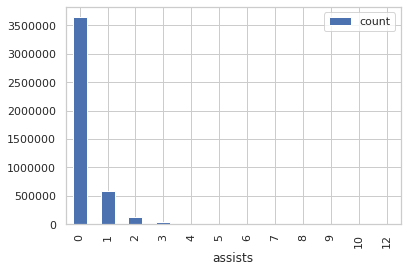

In [19]:
data.groupBy('assists').count().orderBy(col('count').desc()).toPandas().set_index('assists').plot(kind='bar')

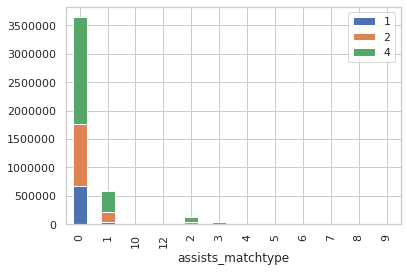

In [20]:
cross_tab = data.crosstab('assists', 'matchtype').toPandas().sort_values(by=["assists_matchtype"]).set_index('assists_matchtype')
cross_tab.plot.bar(stacked=True)

In [44]:
sqlCtx.sql("""SELECT matchtype, min(assists), max(assists), avg(assists) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(assists), max(assists), avg(assists) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+------------+------------+-------------------+
|matchtype|min(assists)|max(assists)|       avg(assists)|
+---------+------------+------------+-------------------+
|        1|           0|           5| 0.0571278300941695|
|        2|           0|           9|0.21529640184326732|
|        4|           0|          12|0.28794038054116483|
+---------+------------+------------+-------------------+

+-------------+------------+------------+--------------------+
|winPlaceClass|min(assists)|max(assists)|        avg(assists)|
+-------------+------------+------------+--------------------+
|            1|           0|          10|  1.0810592294330017|
|            2|           0|          12|  0.4474846971761747|
|            3|           0|           8| 0.22653492925083185|
|            4|           0|           6| 0.13713361698266915|
|            5|           0|           5| 0.07948807869702444|
|            6|           0|           4|0.029951597556435044|
+-------------+-----------

## boosts

number of boost items used. Both 'boosts' and 'heals' variables are items that restore health. But the boosts immediately show the effect, and the heals show the effect slowly.

In [21]:
data.select('boosts').summary().show()

+-------+------------------+
|summary|            boosts|
+-------+------------------+
|  count|           4411698|
|   mean|1.1049192397122378|
| stddev|1.7146506619500843|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 2|
|    max|                33|
+-------+------------------+



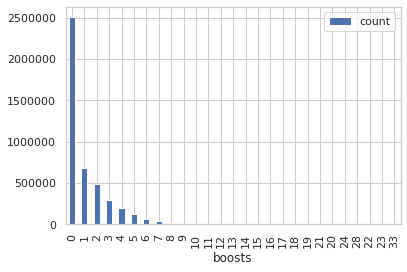

In [23]:
data.groupBy('boosts').count().orderBy(col('count').desc()).toPandas().set_index('boosts').plot(kind='bar')

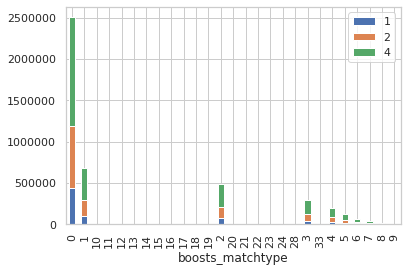

In [25]:
cross_tab = data.crosstab('boosts', 'matchtype').toPandas().sort_values(by=["boosts_matchtype"]).set_index('boosts_matchtype')
cross_tab.plot.bar(stacked=True)

In [45]:
sqlCtx.sql("""SELECT matchtype, min(boosts), max(boosts), avg(boosts) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(boosts), max(boosts), avg(boosts) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+-----------+-----------+------------------+
|matchtype|min(boosts)|max(boosts)|       avg(boosts)|
+---------+-----------+-----------+------------------+
|        1|          0|         28|1.0607691066141276|
|        2|          0|         21|1.0912963774210438|
|        4|          0|         33|1.1257277421694272|
+---------+-----------+-----------+------------------+

+-------------+-----------+-----------+--------------------+
|winPlaceClass|min(boosts)|max(boosts)|         avg(boosts)|
+-------------+-----------+-----------+--------------------+
|            1|          0|         21|  3.9186766036134837|
|            2|          0|         33|   2.773843080786258|
|            3|          0|         17|  1.2887702500588176|
|            4|          0|         16| 0.43909918969033584|
|            5|          0|          9| 0.09254890819420337|
|            6|          0|         24|0.009515010273453122|
+-------------+-----------+-----------+--------------------+



## damageDealt

total damage dealt. Note: Self inflicted damage is subtracted. If it is not headshot, it does not die in one shot. So restores health by using boosts or heals. 'damageDealt' means how many bullets have ever been hit.

In [27]:
data.select('damageDealt').summary().show()

+-------+------------------+
|summary|       damageDealt|
+-------+------------------+
|  count|           4411698|
|   mean|129.26890968896862|
| stddev|165.55830220522043|
|    min|               0.0|
|    25%|               0.0|
|    50%|             83.85|
|    75%|             185.1|
|    max|            3796.0|
+-------+------------------+



  damageDealt  frequency
0        0.00    4076280
1      379.60     291297
2      759.20      37281
3     1138.80       5576
4     1518.40        970
5     1898.00        227
6     2277.60         48
7     2657.20         11
8     3036.80          7
9     3416.40          1


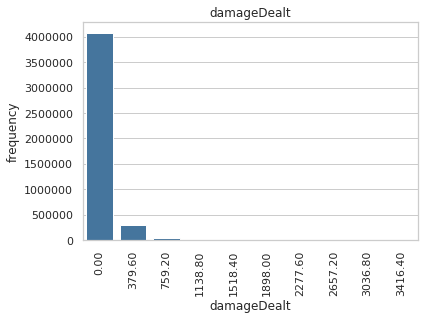

In [26]:
histogram('damageDealt', bins=10)

In [46]:
sqlCtx.sql("""SELECT matchtype, min(damageDealt), max(damageDealt), avg(damageDealt) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(damageDealt), max(damageDealt), avg(damageDealt) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------------+----------------+------------------+
|matchtype|min(damageDealt)|max(damageDealt)|  avg(damageDealt)|
+---------+----------------+----------------+------------------+
|        1|             0.0|          2490.0|117.32300234366896|
|        2|             0.0|          3240.0|130.83090019705972|
|        4|             0.0|          3796.0|132.01322933224137|
+---------+----------------+----------------+------------------+

+-------------+----------------+----------------+------------------+
|winPlaceClass|min(damageDealt)|max(damageDealt)|  avg(damageDealt)|
+-------------+----------------+----------------+------------------+
|            1|             0.0|          3796.0| 407.8356599194678|
|            2|             0.0|          3407.0|226.75545590696012|
|            3|             0.0|          2297.0|136.26367372512982|
|            4|             0.0|          1718.0| 97.31247342961642|
|            5|             0.0|          1086.0| 61.22833583

## DBNOs
number of enemy players knocked. DBNOs variable means Number of enemy players knocked. Knocked is not dead, but can not act. so if you are knocked, your colleagues can save you (revives variable) but if you died? you don't save... :(

In [28]:
data.select('DBNOs').summary().show()

+-------+------------------+
|summary|             DBNOs|
+-------+------------------+
|  count|           4411698|
|   mean|0.6541451840085155|
| stddev|1.1241384530222183|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                32|
+-------+------------------+



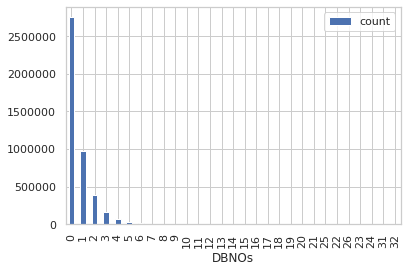

In [29]:
data.groupBy('DBNOs').count().orderBy(col('count').desc()).toPandas().set_index('DBNOs').plot(kind='bar')

In [31]:
sqlCtx.sql("""SELECT distinct(DBNOs) FROM pubg where matchtype == 1""").show()

+-----+
|DBNOs|
+-----+
|    0|
+-----+



Si osserva che DBNOs è sempre 0 per i match di tipo 'solo'

In [47]:
sqlCtx.sql("""SELECT matchtype, min(DBNOs), max(DBNOs), avg(DBNOs) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(DBNOs), max(DBNOs), avg(DBNOs) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------+----------+------------------+
|matchtype|min(DBNOs)|max(DBNOs)|        avg(DBNOs)|
+---------+----------+----------+------------------+
|        1|         0|         0|               0.0|
|        2|         0|        31|0.6242763008268449|
|        4|         0|        32| 0.867882060442051|
+---------+----------+----------+------------------+

+-------------+----------+----------+-------------------+
|winPlaceClass|min(DBNOs)|max(DBNOs)|         avg(DBNOs)|
+-------------+----------+----------+-------------------+
|            1|         0|        32|  2.018459666509234|
|            2|         0|        25|  1.035900119120247|
|            3|         0|        31| 0.6849004722212886|
|            4|         0|        24|  0.534603076795128|
|            5|         0|        15|0.36963363800611715|
|            6|         0|         5| 0.1539501082504792|
+-------------+----------+----------+-------------------+



## headshotKills
number of enemy players head-shotted's. It means that a bullet hit his head and he died right away. It's important that he died right away.

In [34]:
data.select('headshotKills').summary().show()

+-------+-------------------+
|summary|      headshotKills|
+-------+-------------------+
|  count|            4411698|
|   mean|0.22373176949102136|
| stddev| 0.5859880788905978|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  0|
|    max|                 26|
+-------+-------------------+



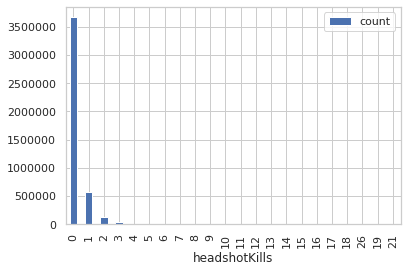

In [35]:
data.groupBy('headshotKills').count().orderBy(col('count').desc()).toPandas().set_index('headshotKills').plot(kind='bar')

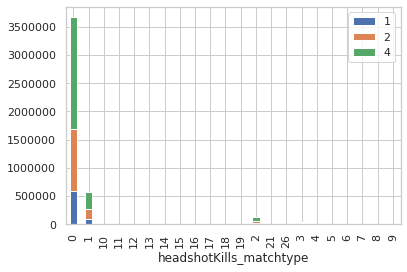

In [36]:
cross_tab = data.crosstab('headshotKills', 'matchtype').toPandas().sort_values(by=["headshotKills_matchtype"]).set_index('headshotKills_matchtype')
cross_tab.plot.bar(stacked=True)

In [48]:
sqlCtx.sql("""SELECT matchtype, min(headshotKills), max(headshotKills), avg(headshotKills) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(headshotKills), max(headshotKills), avg(headshotKills) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+------------------+------------------+-------------------+
|matchtype|min(headshotKills)|max(headshotKills)| avg(headshotKills)|
+---------+------------------+------------------+-------------------+
|        1|                 0|                19|0.24453321534317327|
|        2|                 0|                17| 0.2220331195879971|
|        4|                 0|                26| 0.2183914799606499|
+---------+------------------+------------------+-------------------+

+-------------+------------------+------------------+--------------------+
|winPlaceClass|min(headshotKills)|max(headshotKills)|  avg(headshotKills)|
+-------------+------------------+------------------+--------------------+
|            1|                 0|                26|  0.9423795838970229|
|            2|                 0|                17|  0.4366620169384488|
|            3|                 0|                17|  0.2278499226968709|
|            4|                 0|                11|  0.14

## heals
 number of healing items used. See difference with 'boots'.

In [38]:
data.select('heals').summary().show()

+-------+------------------+
|summary|             heals|
+-------+------------------+
|  count|           4411698|
|   mean|1.3620658077683467|
| stddev| 2.669458631778128|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 2|
|    max|                80|
+-------+------------------+



   heals  frequency
0   0.00    4240944
1   8.00     151314
2  16.00      16648
3  24.00       2244
4  32.00        414
5  40.00         91
6  48.00         33
7  56.00          8
8  64.00          0
9  72.00          2


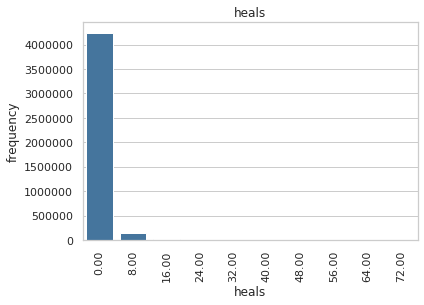

In [40]:
histogram('heals', bins=10)

In [43]:
sqlCtx.sql("""SELECT matchtype, min(heals), max(heals), avg(heals) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(heals), max(heals), avg(heals) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------+----------+------------------+
|matchtype|min(heals)|max(heals)|        avg(heals)|
+---------+----------+----------+------------------+
|        1|         0|        63|  1.01029909392462|
|        2|         0|        62|1.3312561723354208|
|        4|         0|        80|1.4851127622641762|
+---------+----------+----------+------------------+

+-------------+----------+----------+-------------------+
|winPlaceClass|min(heals)|max(heals)|         avg(heals)|
+-------------+----------+----------+-------------------+
|            1|         0|        54|  3.426181346611058|
|            2|         0|        80|  3.034564171074259|
|            3|         0|        61| 1.8336501781332974|
|            4|         0|        42| 0.7611949185059455|
|            5|         0|        21|0.17427519987215284|
|            6|         0|        31|0.01487007644184582|
+-------------+----------+----------+-------------------+



## killPlace
ranking in match of number of enemy players killed.

In [49]:
data.select('killPlace').summary().show()

+-------+------------------+
|summary|         killPlace|
+-------+------------------+
|  count|           4411698|
|   mean|47.728825499841555|
| stddev|27.460104599625414|
|    min|                 1|
|    25%|                24|
|    50%|                48|
|    75%|                71|
|    max|               100|
+-------+------------------+



  killPlace  frequency
0      1.00     471834
1     10.90     470426
2     20.80     467164
3     30.70     466806
4     40.60     465452
5     50.50     464698
6     60.40     463841
7     70.30     462382
8     80.20     448934
9     90.10     230161


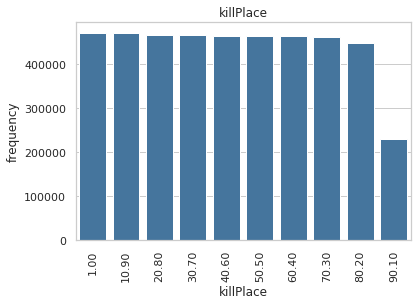

In [50]:
histogram('killPlace', bins=10)

In [51]:
sqlCtx.sql("""SELECT matchtype, min(killPlace), max(killPlace), avg(killPlace) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(killPlace), max(killPlace), avg(killPlace) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------+--------------+------------------+
|matchtype|min(killPlace)|max(killPlace)|    avg(killPlace)|
+---------+--------------+--------------+------------------+
|        1|             1|           100| 47.55640708831452|
|        2|             1|           100| 47.58376975338133|
|        4|             1|           100|47.860600441849456|
+---------+--------------+--------------+------------------+

+-------------+--------------+--------------+------------------+
|winPlaceClass|min(killPlace)|max(killPlace)|    avg(killPlace)|
+-------------+--------------+--------------+------------------+
|            1|             1|            57|12.063752291448194|
|            2|             1|            64|24.030390137572628|
|            3|             1|            76| 37.39174305952341|
|            4|             1|            89| 50.80241826495066|
|            5|             1|           100| 69.96649960713636|
|            6|             1|           100| 84.964

## killPoints
kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) **If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.**

In [52]:
data.filter(col('killPoints') > 0).select('killPoints').summary().show()

+-------+------------------+
|summary|        killPoints|
+-------+------------------+
|  count|           1778774|
|   mean|1255.4712959600265|
| stddev|196.80971916710467|
|    min|               134|
|    25%|              1094|
|    50%|              1242|
|    75%|              1388|
|    max|              2170|
+-------+------------------+



  killPoints  frequency
0     134.00       2028
1     337.60       2213
2     541.20        182
3     744.80       1146
4     948.40     602611
5    1152.00     637339
6    1355.60     405683
7    1559.20     110927
8    1762.80      16076
9    1966.40        569


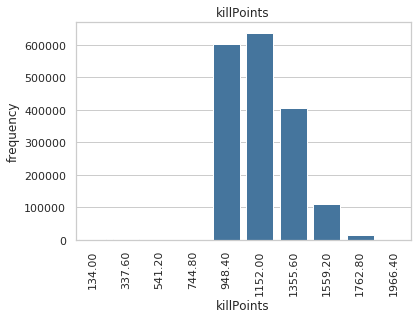

In [55]:
rdd = spark.sql(f'SELECT killPoints FROM pubg where killPoints > 0').rdd.map(lambda x: x[0])
hist = rdd.histogram(10)
df = pd.DataFrame(list(zip(*hist)), columns=['killPoints', 'frequency'])
df['killPoints'] = df['killPoints'].apply(lambda x: f'{x:.2f}')
print(df.head(10))
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = 'killPoints', y = 'frequency', data = df, color='#3776ab')
ax.set(xlabel='killPoints', ylabel='frequency')
ax.tick_params(axis='x', rotation=90)
plt.title('killPoints')
plt.show()

In [57]:
sqlCtx.sql("""SELECT matchtype, min(killPoints), max(killPoints), avg(killPoints) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(killPoints), max(killPoints), avg(killPoints) FROM pubg group by winPlaceClass order by winPlaceClass""").show()
# where killPoints > 0
sqlCtx.sql("""SELECT matchtype, min(killPoints), max(killPoints), avg(killPoints) FROM pubg where killPoints > 0 group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(killPoints), max(killPoints), avg(killPoints) FROM pubg where killPoints > 0 group by winPlaceClass order by winPlaceClass""").show()

+---------+---------------+---------------+------------------+
|matchtype|min(killPoints)|max(killPoints)|   avg(killPoints)|
+---------+---------------+---------------+------------------+
|        1|              0|           1970|  447.282327634186|
|        2|              0|           1967|475.47549153540996|
|        4|              0|           2170| 540.8665096746901|
+---------+---------------+---------------+------------------+

+-------------+---------------+---------------+------------------+
|winPlaceClass|min(killPoints)|max(killPoints)|   avg(killPoints)|
+-------------+---------------+---------------+------------------+
|            1|              0|           2140| 567.1816588083669|
|            2|              0|           2156| 514.2941058529749|
|            3|              0|           2152|503.28816631936274|
|            4|              0|           2170| 500.9662749004361|
|            5|              0|           2125|505.85394794667707|
|            6|       

## kills
number of enemy players killed.
composed by 'headshotKills', 'roadKills', not 'teamKills'

In [58]:
data.select('kills').summary().show()
data.select(['kills', 'headshotKills', 'roadKills']).show(5)

+-------+------------------+
|summary|             kills|
+-------+------------------+
|  count|           4411698|
|   mean|0.9116072768353591|
| stddev|1.5010820312237814|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                33|
+-------+------------------+

+-----+-------------+---------+
|kills|headshotKills|roadKills|
+-----+-------------+---------+
|    0|            0|        0|
|    0|            0|        0|
|    0|            0|        0|
|    0|            0|        0|
|    1|            0|        0|
+-----+-------------+---------+
only showing top 5 rows



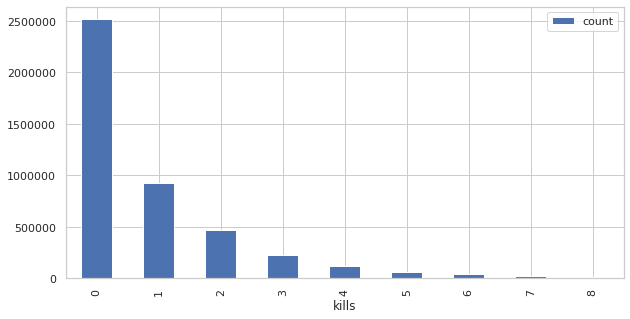

In [59]:
#df_pandas.kills.hist()
df = data.groupBy('kills').count().orderBy(col('count').desc()).toPandas().set_index('kills')
df[df['count'] > 10000].plot(kind='bar', figsize=(10,5))

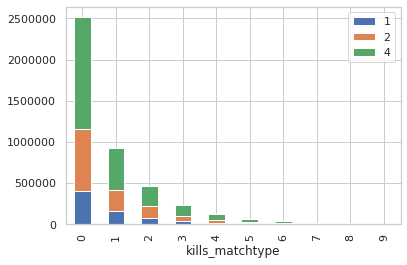

In [60]:
cross_tab = data.crosstab('kills', 'matchtype').toPandas().sort_values(by=["kills_matchtype"]).set_index('kills_matchtype')
cross_tab[cross_tab > 1000].dropna().plot.bar(stacked=True)

In [61]:
sqlCtx.sql("""SELECT matchtype, min(kills), max(kills), avg(kills) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(kills), max(kills), avg(kills) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------+----------+------------------+
|matchtype|min(kills)|max(kills)|        avg(kills)|
+---------+----------+----------+------------------+
|        1|         0|        23|0.9185798325875465|
|        2|         0|        22|0.9217496691551895|
|        4|         0|        33|0.9039267020101465|
+---------+----------+----------+------------------+

+-------------+----------+----------+-------------------+
|winPlaceClass|min(kills)|max(kills)|         avg(kills)|
+-------------+----------+----------+-------------------+
|            1|         0|        33|  3.563019828531632|
|            2|         0|        23| 1.7483485602104065|
|            3|         0|        18| 0.9467060044365274|
|            4|         0|        16| 0.6197101635551557|
|            5|         0|        10|0.32792172913272577|
|            6|         0|         5|0.08997430487563836|
+-------------+----------+----------+-------------------+



## killStreaks
max number of enemy players killed in a short amount of time.

In [62]:
data.select('kills').summary().show()

+-------+------------------+
|summary|             kills|
+-------+------------------+
|  count|           4411698|
|   mean|0.9116072768353591|
| stddev|1.5010820312237814|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                33|
+-------+------------------+



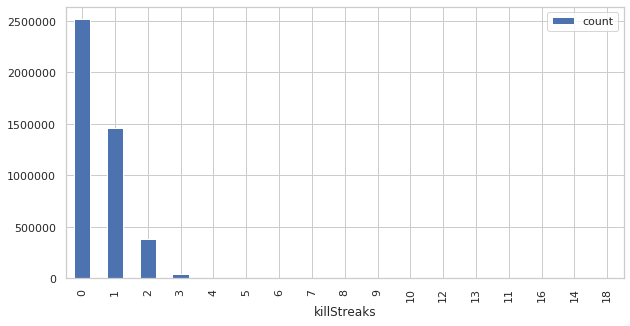

In [64]:
data.groupBy('killStreaks').count().orderBy(col('count').desc()).toPandas().set_index('killStreaks').plot(kind='bar', figsize=(10,5))

In [66]:
sqlCtx.sql("""SELECT matchtype, min(killStreaks), max(killStreaks), avg(killStreaks) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(killStreaks), max(killStreaks), avg(killStreaks) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------------+----------------+-------------------+
|matchtype|min(killStreaks)|max(killStreaks)|   avg(killStreaks)|
+---------+----------------+----------------+-------------------+
|        1|               0|              18|0.47244484516574276|
|        2|               0|              10| 0.5616012430911819|
|        4|               0|              10| 0.5517372640923452|
+---------+----------------+----------------+-------------------+

+-------------+----------------+----------------+-------------------+
|winPlaceClass|min(killStreaks)|max(killStreaks)|   avg(killStreaks)|
+-------------+----------------+----------------+-------------------+
|            1|               0|              18| 1.3087711433626052|
|            2|               0|              13|  0.881885466579319|
|            3|               0|              14| 0.6113889775820925|
|            4|               0|              16| 0.4618094080600011|
|            5|               0|              1

## longestKill
longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

In [67]:
data.select('longestKill').summary().show()

+-------+------------------+
|summary|       longestKill|
+-------+------------------+
|  count|           4411698|
|   mean|22.837279579268337|
| stddev| 50.65590048388228|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|             21.12|
|    max|            1003.0|
+-------+------------------+



In [69]:
data.filter(col('longestKill') > 0).select('longestKill').summary().show()

+-------+-----------------+
|summary|      longestKill|
+-------+-----------------+
|  count|          1888976|
|   mean|53.33640059233095|
| stddev|66.07738281059966|
|    min|           0.0178|
|    25%|             11.0|
|    50%|            28.11|
|    75%|            70.27|
|    max|           1003.0|
+-------+-----------------+



  longestKill  frequency
0        0.00    4102771
1      100.30     227944
2      200.60      61562
3      300.90      14347
4      401.20       3384
5      501.50        972
6      601.80        338
7      702.10        165
8      802.40        113
9      902.70        102


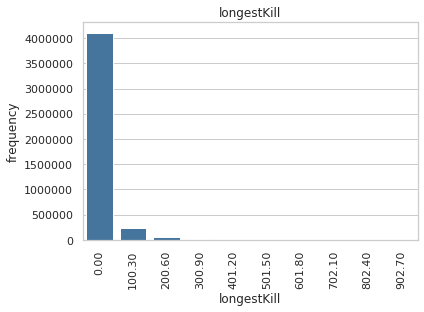

In [68]:
histogram('longestKill', bins=10)

In [72]:
sqlCtx.sql("""SELECT matchtype, min(longestKill), max(longestKill), avg(longestKill) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(longestKill), max(longestKill), avg(longestKill) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+----------------+----------------+------------------+
|matchtype|min(longestKill)|max(longestKill)|  avg(longestKill)|
+---------+----------------+----------------+------------------+
|        1|             0.0|          1001.0| 21.44753243560629|
|        2|             0.0|          1003.0|22.336051233322145|
|        4|             0.0|          1000.0|23.532104346475457|
+---------+----------------+----------------+------------------+

+-------------+----------------+----------------+------------------+
|winPlaceClass|min(longestKill)|max(longestKill)|  avg(longestKill)|
+-------------+----------------+----------------+------------------+
|            1|             0.0|          1003.0| 98.62605938633246|
|            2|             0.0|          1001.0|52.100818887688924|
|            3|             0.0|           994.5|  24.7398808490949|
|            4|             0.0|           989.4|10.967357750582638|
|            5|             0.0|           994.3| 3.995353648

## matchDuration
duration of whole single/teammate match in seconds.
Uguale per tutti all'interno di un match

In [70]:
data.where(col('matchid') == 'aeb375fc57110c').select(['groupId', 'matchDuration']).show(10)

+--------------+-------------+
|       groupId|matchDuration|
+--------------+-------------+
|684d5656442f9e|         1777|
|557ca8543fb0dd|         1777|
|b9e8b77c01059b|         1777|
|4c526bf789bcf4|         1777|
|766390c7622843|         1777|
|44961cf90f1aba|         1777|
|766390c7622843|         1777|
|b88c63770f6f54|         1777|
|4c526bf789bcf4|         1777|
|645894055adb04|         1777|
+--------------+-------------+
only showing top 10 rows



In [71]:
data.select('matchDuration').summary().show()

+-------+------------------+
|summary|     matchDuration|
+-------+------------------+
|  count|           4411698|
|   mean|1580.7029753623208|
| stddev| 254.4928844346351|
|    min|               728|
|    25%|              1367|
|    50%|              1438|
|    75%|              1850|
|    max|              2237|
+-------+------------------+



  matchDuration  frequency
0        728.00         12
1        878.90        130
2       1029.80       9271
3       1180.70     560512
4       1331.60    1909413
5       1482.50      82405
6       1633.40     279583
7       1784.30    1239466
8       1935.20     301364
9       2086.10      29542


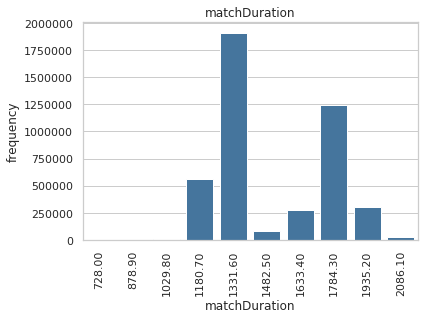

In [73]:
histogram('matchDuration', bins=10)

Si hanno due durate di match differenti.
La durata del match dipende dalla mappa (in fondo al notebook una possibile spiegazione)

In [74]:
sqlCtx.sql("""SELECT matchtype, min(matchDuration), max(matchDuration), avg(matchDuration) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(matchDuration), max(matchDuration), avg(matchDuration) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+------------------+------------------+------------------+
|matchtype|min(matchDuration)|max(matchDuration)|avg(matchDuration)|
+---------+------------------+------------------+------------------+
|        1|               950|              2237|1602.2195312673923|
|        2|               840|              2204|1594.9095820594346|
|        4|               728|              2226| 1566.400493219491|
+---------+------------------+------------------+------------------+

+-------------+------------------+------------------+------------------+
|winPlaceClass|min(matchDuration)|max(matchDuration)|avg(matchDuration)|
+-------------+------------------+------------------+------------------+
|            1|               728|              2237| 1575.821255033181|
|            2|               972|              2237|1581.8083654364723|
|            3|               840|              2237|1578.8346847376736|
|            4|               840|              2237| 1578.979333984807|
|    

## maxPlace
worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.


Dipende dal tipo di match, come numGroups

In [4]:
sqlCtx.sql("""SELECT count(distinct(maxPlace)) from pubg""").show()

+------------------------+
|count(DISTINCT maxPlace)|
+------------------------+
|                     100|
+------------------------+



In [75]:
data.select('maxPlace').summary().show()

+-------+------------------+
|summary|          maxPlace|
+-------+------------------+
|  count|           4411698|
|   mean|44.678357176760514|
| stddev| 23.80913546335595|
|    min|                 2|
|    25%|                28|
|    50%|                30|
|    75%|                49|
|    max|               100|
+-------+------------------+



  maxPlace  frequency
0     2.00        805
1    11.80      16908
2    21.60    2329683
3    31.40      59510
4    41.20    1294566
5    51.00       2548
6    60.80       1856
7    70.60       3961
8    80.40      40964
9    90.20     660897


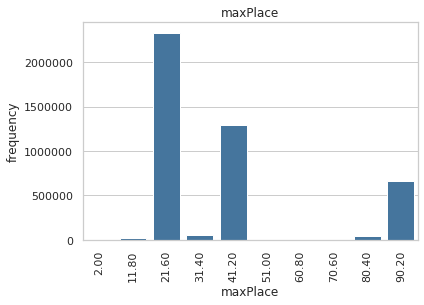

In [76]:
histogram('maxPlace', bins=10)

si hanno 3 tipi di maxPlace differenti: 
- <=100 per matchtype=solo
- <=50 per matchtype=duo
- <=25 per matchtype=squad

In [77]:
sqlCtx.sql("""SELECT matchtype, min(maxPlace), max(maxPlace), avg(maxPlace) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(maxPlace), max(maxPlace), avg(maxPlace) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+-------------+-------------+------------------+
|matchtype|min(maxPlace)|max(maxPlace)|     avg(maxPlace)|
+---------+-------------+-------------+------------------+
|        1|            8|          100| 94.11281417662904|
|        2|            4|           51| 47.71124002314006|
|        4|            2|           37|28.099486635396975|
+---------+-------------+-------------+------------------+

+-------------+-------------+-------------+-----------------+
|winPlaceClass|min(maxPlace)|max(maxPlace)|    avg(maxPlace)|
+-------------+-------------+-------------+-----------------+
|            1|            2|          100|36.25442479647137|
|            2|            6|          100|46.35698976380739|
|            3|            4|          100|46.02764742210869|
|            4|            4|          100|45.34888679291645|
|            5|            5|          100|44.05785882655847|
|            6|            2|          100| 36.3651741430745|
+-------------+-------------

## numGroups
number of groups we have data for in the match.

In [6]:
sqlCtx.sql("""SELECT count(distinct(numGroups)) from pubg""").show()

+-------------------------+
|count(DISTINCT numGroups)|
+-------------------------+
|                      100|
+-------------------------+



In [78]:
data.select('numGroups').summary().show()

+-------+------------------+
|summary|         numGroups|
+-------+------------------+
|  count|           4411698|
|   mean| 43.17773383400224|
| stddev|23.273124609259003|
|    min|                 1|
|    25%|                27|
|    50%|                30|
|    75%|                47|
|    max|               100|
+-------+------------------+



  numGroups  frequency
0      1.00       8056
1     10.90      10403
2     20.80    2298739
3     30.70     107251
4     40.60    1278285
5     50.50       1714
6     60.40       2824
7     70.30      10416
8     80.20     146077
9     90.10     547933


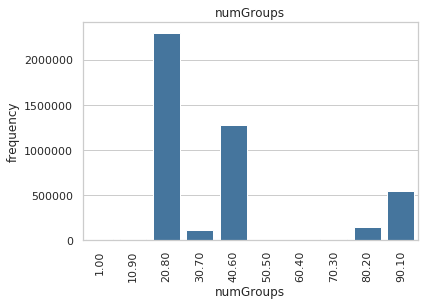

In [79]:
histogram('numGroups', bins=10)

In [80]:
sqlCtx.sql("""SELECT matchtype, min(numGroups), max(numGroups), avg(numGroups) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(numGroups), max(numGroups), avg(numGroups) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------+--------------+------------------+
|matchtype|min(numGroups)|max(numGroups)|    avg(numGroups)|
+---------+--------------+--------------+------------------+
|        1|             1|           100| 91.32680908969478|
|        2|             4|            51| 45.91257683460507|
|        4|             2|            37|27.150472234999445|
+---------+--------------+--------------+------------------+

+-------------+--------------+--------------+------------------+
|winPlaceClass|min(numGroups)|max(numGroups)|    avg(numGroups)|
+-------------+--------------+--------------+------------------+
|            1|             2|           100|34.904067370578204|
|            2|             6|           100| 44.83730061297071|
|            3|             4|           100| 44.57038050784795|
|            4|             4|           100|  43.8697503293596|
|            5|             5|           100| 42.58489983086887|
|            6|             1|           100|34.4225

## rankPoints
Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. **Value of -1 takes place of “None”.**

In [81]:
data.select('rankPoints').summary().show()

+-------+-----------------+
|summary|       rankPoints|
+-------+-----------------+
|  count|          4411698|
|   mean|891.4181822962496|
| stddev|736.7605919566126|
|    min|               -1|
|    25%|               -1|
|    50%|             1443|
|    75%|             1500|
|    max|             5910|
+-------+-----------------+



In [82]:
data.filter(col('rankPoints') >= 0).select('rankPoints').summary().show()

+-------+------------------+
|summary|        rankPoints|
+-------+------------------+
|  count|           2722102|
|   mean|1445.3379807222507|
| stddev|280.32876845685416|
|    min|                 0|
|    25%|              1460|
|    50%|              1494|
|    75%|              1512|
|    max|              5910|
+-------+------------------+



  rankPoints  frequency
0      -1.00    1779383
1     590.10       8196
2    1181.20    2586101
3    1772.30      37165
4    2363.40        673
5    2954.50         93
6    3545.60         44
7    4136.70         14
8    4727.80         12
9    5318.90         17


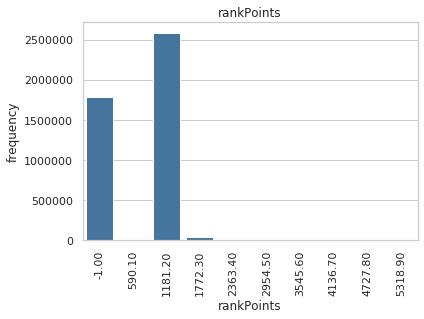

In [83]:
histogram('rankPoints', bins=10)

In [86]:
sqlCtx.sql("""SELECT matchtype, min(rankPoints), max(rankPoints), avg(rankPoints) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(rankPoints), max(rankPoints), avg(rankPoints) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+---------------+---------------+-----------------+
|matchtype|min(rankPoints)|max(rankPoints)|  avg(rankPoints)|
+---------+---------------+---------------+-----------------+
|        1|             -1|           2857|967.1838392439724|
|        2|             -1|           3725|920.2899513234555|
|        4|             -1|           5910|852.6878447751974|
+---------+---------------+---------------+-----------------+

+-------------+---------------+---------------+-----------------+
|winPlaceClass|min(rankPoints)|max(rankPoints)|  avg(rankPoints)|
+-------------+---------------+---------------+-----------------+
|            1|             -1|           5635| 918.813914393897|
|            2|             -1|           5725|905.3825529045076|
|            3|             -1|           5289|893.8284616257184|
|            4|             -1|           5698|889.2499607792734|
|            5|             -1|           5910|878.0832986340774|
|            6|             -1|      

## revives
 number of times this player revived teammates. I said above, if you knock, your teammates can save you. If a team member is saved, the revives are +1.
 

In [87]:
data.select('revives').summary().show()

+-------+-------------------+
|summary|            revives|
+-------+-------------------+
|  count|            4411698|
|   mean|0.16427688386648406|
| stddev|0.47083940184972856|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  0|
|    max|                 39|
+-------+-------------------+



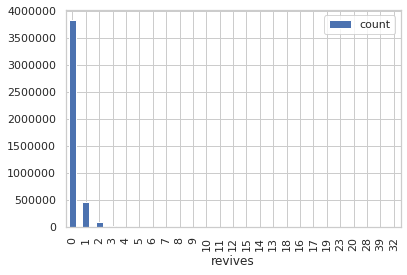

In [88]:
data.groupBy('revives').count().orderBy(col('count').desc()).toPandas().set_index('revives').plot(kind='bar')

In [89]:
sqlCtx.sql("""SELECT matchtype, min(revives), max(revives), avg(revives) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(revives), max(revives), avg(revives) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+------------+------------+-------------------+
|matchtype|min(revives)|max(revives)|       avg(revives)|
+---------+------------+------------+-------------------+
|        1|           0|           0|                0.0|
|        2|           0|          39|0.15947559380347132|
|        4|           0|          23|0.21646846114847285|
+---------+------------+------------+-------------------+

+-------------+------------+------------+--------------------+
|winPlaceClass|min(revives)|max(revives)|        avg(revives)|
+-------------+------------+------------+--------------------+
|            1|           0|          19|  0.4835696159973103|
|            2|           0|          39|  0.3111107775410622|
|            3|           0|          28| 0.19852934998151447|
|            4|           0|          23| 0.12429379065015679|
|            5|           0|          15| 0.04649463530268257|
|            6|           0|           3|0.005805535253802557|
+-------------+-----------

revives in modalità di gioco 'solo' è sempre uguale a zero

## distance (swimDistance, walkDistance, rideDistance)
Nuova variabile "distance" definita come la somma di swimDistance, walkDistance e rideDistance.

rideDistance: total distance traveled in vehicles measured in meters. The PUBG game is so wide that it is hard to walk around.

swimDistance: total distance traveled by swimming measured in meters. The map is wide, and there are some kind of river.

walkDistance: total distance traveled on foot measured in meters.

In [90]:
data = data.withColumn("distance", data['swimDistance'] + data['walkDistance'] + data['rideDistance'])
data.createOrReplaceTempView("pubg")
data.select('distance').summary().show()
data.select(['distance','swimDistance', 'walkDistance','rideDistance']).show(5)

+-------+------------------+
|summary|          distance|
+-------+------------------+
|  count|           4411698|
|   mean|1754.1804126073525|
| stddev| 2172.929751875514|
|    min|               0.0|
|    25%|             157.4|
|    50%|             780.0|
|    75%|            2714.0|
|    max|           41270.1|
+-------+------------------+

+---------+------------+------------+------------+
| distance|swimDistance|walkDistance|rideDistance|
+---------+------------+------------+------------+
|    244.8|         0.0|       244.8|         0.0|
|1445.0445|       11.04|      1434.0|      0.0045|
|    161.8|         0.0|       161.8|         0.0|
|    202.7|         0.0|       202.7|         0.0|
|    49.75|         0.0|       49.75|         0.0|
+---------+------------+------------+------------+
only showing top 5 rows



   distance  frequency
0      0.00    3850098
1   4127.01     478660
2   8254.02      77606
3  12381.03       4823
4  16508.04        347
5  20635.05         94
6  24762.06         42
7  28889.07         23
8  33016.08          2
9  37143.09          3


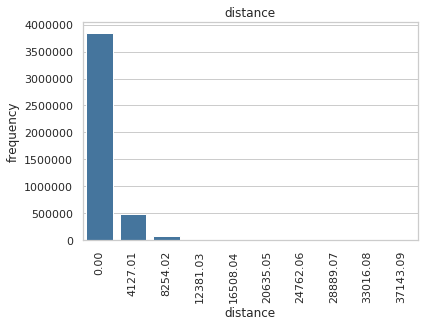

  swimDistance  frequency
0         0.00    4404448
1       351.40       6507
2       702.80        632
3      1054.20         83
4      1405.60         13
5      1757.00          4
6      2108.40          7
7      2459.80          3
8      2811.20          0
9      3162.60          1


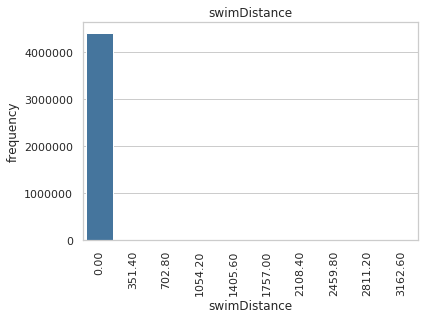

  walkDistance  frequency
0         0.00    3752211
1      2578.00     645777
2      5156.00      12424
3      7734.00       1118
4     10312.00        147
5     12890.00         19
6     15468.00          1
7     18046.00          0
8     20624.00          0
9     23202.00          1


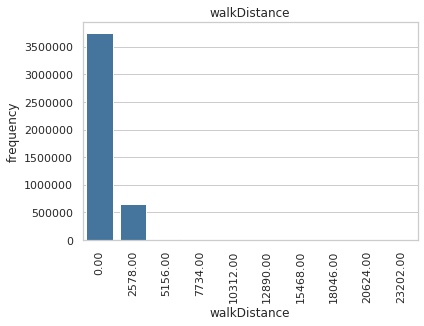

  rideDistance  frequency
0         0.00    4198485
1      4071.00     192983
2      8142.00      18622
3     12213.00       1262
4     16284.00        205
5     20355.00         71
6     24426.00         45
7     28497.00         21
8     32568.00          2
9     36639.00          2


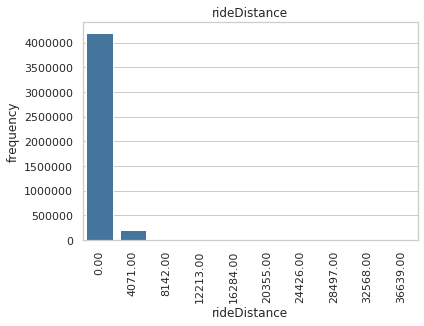

In [92]:
histogram('distance', bins=10)
histogram('swimDistance', bins=10)
histogram('walkDistance', bins=10)
histogram('rideDistance', bins=10)

In [93]:
sqlCtx.sql("""SELECT matchtype, min(distance), max(distance), avg(distance) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(distance), max(distance), avg(distance) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

sqlCtx.sql("""SELECT matchtype, min(swimDistance), max(swimDistance), avg(swimDistance) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(swimDistance), max(swimDistance), avg(swimDistance) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

sqlCtx.sql("""SELECT matchtype, min(walkDistance), max(walkDistance), avg(walkDistance) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(walkDistance), max(walkDistance), avg(walkDistance) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

sqlCtx.sql("""SELECT matchtype, min(rideDistance), max(rideDistance), avg(rideDistance) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(rideDistance), max(rideDistance), avg(rideDistance) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+-------------+-------------+------------------+
|matchtype|min(distance)|max(distance)|     avg(distance)|
+---------+-------------+-------------+------------------+
|        1|          0.0|      41270.1|1424.1565111464502|
|        2|          0.0|      31636.2|   1708.9853939368|
|        4|          0.0|      29594.1|1878.5797179070319|
+---------+-------------+-------------+------------------+

+-------------+-------------+-------------+------------------+
|winPlaceClass|min(distance)|max(distance)|     avg(distance)|
+-------------+-------------+-------------+------------------+
|            1|          0.0|      37312.0| 4481.451386139232|
|            2|          0.0|      41270.1|3822.7006870717537|
|            3|          0.0|      38212.1|2529.2908566822002|
|            4|          0.0|     25080.26| 912.9965776408726|
|            5|          0.0|     19854.54|204.24559395771445|
|            6|          0.0|      15647.5| 43.81310614660467|
+-------------+----

## vehicleDestroys
number of vehicles destroyed. We will rarely destroy a vehicle. In fact, it is very natural. It is difficult to destroy the car. And there is no profit by destroying the car. Even so, the destruction of a car can be thought of in the following sense: the enemy was in the car and shot the car, he hid the car in cover and shot the car or he broke a car with no meaning (strange players).

In [94]:
data.select('vehicleDestroys').summary().show()

+-------+--------------------+
|summary|     vehicleDestroys|
+-------+--------------------+
|  count|             4411698|
|   mean|0.007685929544588048|
| stddev|  0.0909029566537879|
|    min|                   0|
|    25%|                   0|
|    50%|                   0|
|    75%|                   0|
|    max|                   5|
+-------+--------------------+



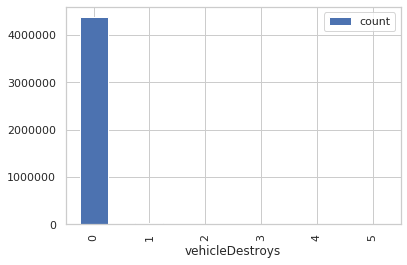

In [95]:
data.groupBy('vehicleDestroys').count().orderBy(col('count').desc()).toPandas().set_index('vehicleDestroys').plot(kind='bar')

In [96]:
sqlCtx.sql("""SELECT matchtype, min(vehicleDestroys), max(vehicleDestroys), avg(vehicleDestroys) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(vehicleDestroys), max(vehicleDestroys), avg(vehicleDestroys) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------------+--------------------+--------------------+
|matchtype|min(vehicleDestroys)|max(vehicleDestroys)|avg(vehicleDestroys)|
+---------+--------------------+--------------------+--------------------+
|        1|                   0|                   5|0.004519245753467353|
|        2|                   0|                   3|0.006948122617879...|
|        4|                   0|                   5| 0.00904683402778011|
+---------+--------------------+--------------------+--------------------+

+-------------+--------------------+--------------------+--------------------+
|winPlaceClass|min(vehicleDestroys)|max(vehicleDestroys)|avg(vehicleDestroys)|
+-------------+--------------------+--------------------+--------------------+
|            1|                   0|                   3|0.029002329472226446|
|            2|                   0|                   5|0.015583201364682723|
|            3|                   0|                   4|0.010774123617786442|


## roadKills
 number of kills while in a vehicle (it's hard to kill if you're in a car).

In [97]:
data.select('roadKills').summary().show()

+-------+--------------------+
|summary|           roadKills|
+-------+--------------------+
|  count|             4411698|
|   mean|0.003010178847237...|
| stddev| 0.06495919528388637|
|    min|                   0|
|    25%|                   0|
|    50%|                   0|
|    75%|                   0|
|    max|                  18|
+-------+--------------------+



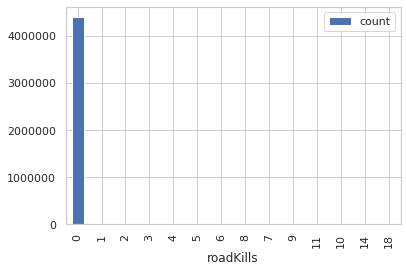

In [98]:
data.groupBy('roadKills').count().orderBy(col('count').desc()).toPandas().set_index('roadKills').plot(kind='bar')

In [99]:
sqlCtx.sql("""SELECT matchtype, min(roadKills), max(roadKills), avg(roadKills) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(roadKills), max(roadKills), avg(roadKills) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------+--------------+--------------------+
|matchtype|min(roadKills)|max(roadKills)|      avg(roadKills)|
+---------+--------------+--------------+--------------------+
|        1|             0|            18| 0.00512311048776687|
|        2|             0|             7|0.002555938339990933|
|        4|             0|             8|0.002622641762831597|
+---------+--------------+--------------+--------------------+

+-------------+--------------+--------------+--------------------+
|winPlaceClass|min(roadKills)|max(roadKills)|      avg(roadKills)|
+-------------+--------------+--------------+--------------------+
|            1|             0|            18|0.007108492567302535|
|            2|             0|            11|  0.0056407886596667|
|            3|             0|             9|0.004232766443719961|
|            4|             0|            14|0.002029081932570...|
|            5|             0|            10|8.123621093004364E-4|
|            6|       

## weaponsAcquired
number of weapons picked up. This game is a using gun , but it does not give a gun from the beginning. So you have to go around the map and look for weapons. In the process, you can also have heals, boosts and vehicles.

In [100]:
data.select('weaponsAcquired').summary().show()

+-------+-----------------+
|summary|  weaponsAcquired|
+-------+-----------------+
|  count|          4411698|
|   mean|3.630741723481526|
| stddev|2.322626795085269|
|    min|                0|
|    25%|                2|
|    50%|                3|
|    75%|                5|
|    max|              236|
+-------+-----------------+



  weaponsAcquired  frequency
0            0.00    4411566
1           23.60        103
2           47.20         13
3           70.80          6
4           94.40          5
5          118.00          1
6          141.60          1
7          165.20          2
8          188.80          0
9          212.40          1


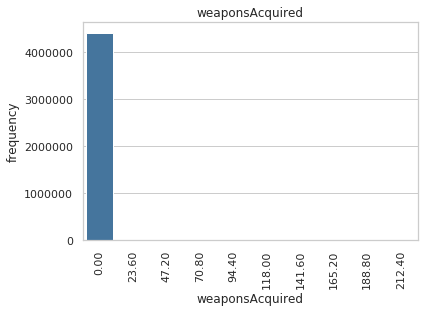

In [103]:
#data.groupBy('weaponsAcquired').count().orderBy(col('count').desc()).toPandas().set_index('weaponsAcquired').plot(kind='bar')
histogram('weaponsAcquired', bins=10)

In [102]:
sqlCtx.sql("""SELECT matchtype, min(weaponsAcquired), max(weaponsAcquired), avg(weaponsAcquired) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(weaponsAcquired), max(weaponsAcquired), avg(weaponsAcquired) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------------+--------------------+--------------------+
|matchtype|min(weaponsAcquired)|max(weaponsAcquired)|avg(weaponsAcquired)|
+---------+--------------------+--------------------+--------------------+
|        1|                   0|                 153|  3.5550880473741624|
|        2|                   0|                 167|  3.6013774134117695|
|        4|                   0|                 236|  3.6697091381585354|
+---------+--------------------+--------------------+--------------------+

+-------------+--------------------+--------------------+--------------------+
|winPlaceClass|min(weaponsAcquired)|max(weaponsAcquired)|avg(weaponsAcquired)|
+-------------+--------------------+--------------------+--------------------+
|            1|                   0|                  85|  5.5658376093691215|
|            2|                   0|                 177|   5.277891132028336|
|            3|                   0|                 236|   4.650723246395321|


## WinPoints
win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

In [104]:
data.select('winPoints').summary().show()

+-------+-----------------+
|summary|        winPoints|
+-------+-----------------+
|  count|          4411698|
|   mean|607.0429301824377|
| stddev|739.8417196696702|
|    min|                0|
|    25%|                0|
|    50%|                0|
|    75%|             1495|
|    max|             2013|
+-------+-----------------+



  winPoints  frequency
0      0.00    2632924
1    201.30        168
2    402.60       1433
3    603.90       2202
4    805.20        523
5   1006.50        129
6   1207.80      43152
7   1409.10    1656876
8   1610.40      72950
9   1811.70       1341


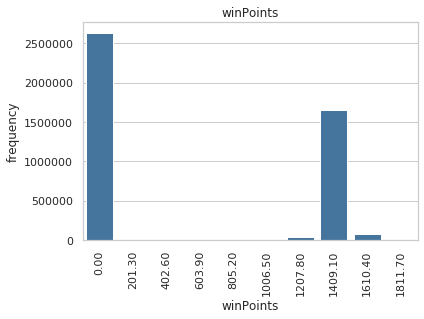

In [105]:
histogram('winPoints', bins=10)

In [106]:
sqlCtx.sql("""SELECT matchtype, min(winPoints), max(winPoints), avg(winPoints) FROM pubg group by matchtype order by matchtype""").show()
sqlCtx.sql("""SELECT winPlaceClass, min(winPoints), max(winPoints), avg(winPoints) FROM pubg group by winPlaceClass order by winPlaceClass""").show()

+---------+--------------+--------------+-----------------+
|matchtype|min(winPoints)|max(winPoints)|   avg(winPoints)|
+---------+--------------+--------------+-----------------+
|        1|             0|          1922|556.9183739063648|
|        2|             0|          1867|588.8196296675067|
|        4|             0|          2013|632.1833507364718|
+---------+--------------+--------------+-----------------+

+-------------+--------------+--------------+-----------------+
|winPlaceClass|min(winPoints)|max(winPoints)|   avg(winPoints)|
+-------------+--------------+--------------+-----------------+
|            1|             0|          2013|627.2367576308227|
|            2|             0|          2000|611.1691893497278|
|            3|             0|          1999|608.8333151278863|
|            4|             0|          1963|605.4467117909791|
|            5|             0|          1958|608.3004221619486|
|            6|             0|          1953|571.1750991721482|
+--

--------------------------------------

In [26]:
categorical_columns = [ 'matchType', 'winPlaceClass']
index_columns = ['Id', 'groupId', 'matchId']
numerical_columns = [ 'assists',
                     'boosts',
                     'damageDealt',
                     'DBNOs',
                     'headshotKills',
                     'heals',
                     'killPlace',
                     'killPoints',
                     'kills',
                     'killStreaks',
                     'longestKill',
                     'matchDuration',
                     'maxPlace',
                     'numGroups',
                     'rankPoints',
                     'revives',
                     'rideDistance',
                     'roadKills',
                     'swimDistance',
                     'teamKills',
                     'vehicleDestroys',
                     'walkDistance',
                     'weaponsAcquired',
                     'winPoints',
                     'winPlacePerc',
                    #'distance'
                    ]

In [35]:
for col in numerical_columns:
    print(f'{col}')
    for group in categorical_columns:
        tmp = sqlCtx.sql("""SELECT """+ group +""", AVG("""+ col +""") FROM pubg GROUP BY """+ group).show()
    
    tmp = sqlCtx.sql("""SELECT """+ ",".join(categorical_columns) +""", AVG("""+ col +""") FROM pubg GROUP BY """+ ",".join(categorical_columns)).show()

assists
+---------+-------------------+
|matchType|       avg(assists)|
+---------+-------------------+
|        1| 0.0571278300941695|
|        4|0.28794038054116483|
|        2|0.21529640184326732|
+---------+-------------------+

+-------------+--------------------+
|winPlaceClass|        avg(assists)|
+-------------+--------------------+
|            1|  1.0810592294330017|
|            6|0.029951597556435044|
|            3| 0.22653492925083185|
|            5| 0.07948807869702444|
|            4| 0.13713361698266915|
|            2|  0.4474846971761747|
+-------------+--------------------+

+---------+-------------+--------------------+
|matchType|winPlaceClass|        avg(assists)|
+---------+-------------+--------------------+
|        2|            2| 0.45186988722608773|
|        2|            3| 0.20647209969159522|
|        1|            2| 0.11154056561139786|
|        1|            1| 0.24196976854038735|
|        1|            3| 0.04909326117401315|
|        2|         

+-------------+-------------------+
|winPlaceClass|         avg(heals)|
+-------------+-------------------+
|            1|  3.426181346611058|
|            6|0.01487007644184582|
|            3| 1.8336501781332974|
|            5|0.17427519987215284|
|            4| 0.7611949185059455|
|            2|  3.034564171074259|
+-------------+-------------------+

+---------+-------------+--------------------+
|matchType|winPlaceClass|          avg(heals)|
+---------+-------------+--------------------+
|        2|            2|   3.044586614507459|
|        2|            3|  1.6869572871211378|
|        1|            2|   2.583426491924934|
|        1|            1|   2.953944260746339|
|        1|            3|  1.1129744356618956|
|        2|            5| 0.11371598956392098|
|        1|            4|  0.4019065519434112|
|        4|            3|   2.171177556233344|
|        2|            1|  3.7151421039326857|
|        2|            4|  0.6466057228071148|
|        4|            6|0.0

+---------+-------------+------------------+
|matchType|winPlaceClass|  avg(longestKill)|
+---------+-------------+------------------+
|        2|            2| 52.26246602112858|
|        2|            3| 22.84606994695169|
|        1|            2| 52.15702675712956|
|        1|            1|105.10069603212098|
|        1|            3| 22.76870798559184|
|        2|            5|  3.24222909274444|
|        1|            4| 8.873458054169014|
|        4|            3|26.566199882217774|
|        2|            1|104.74307315734349|
|        2|            4| 9.753180927160072|
|        4|            6|1.0727126360912715|
|        1|            5| 1.950049087471699|
|        4|            2| 51.97942956771695|
|        4|            4| 12.34572727786273|
|        1|            6|               0.0|
|        4|            1| 96.10005218223999|
|        4|            5| 4.944654246045561|
|        2|            6|0.3849679777469911|
+---------+-------------+------------------+

matchDura

+---------+-----------------+
|matchType|avg(rideDistance)|
+---------+-----------------+
|        1|463.4022729881852|
|        4| 636.369512150482|
|        2|595.6752764610987|
+---------+-----------------+

+-------------+------------------+
|winPlaceClass| avg(rideDistance)|
+-------------+------------------+
|            1| 1473.501449167874|
|            6| 5.247878286930423|
|            3| 952.3010031456922|
|            5| 32.61993997247734|
|            4|305.95090102068366|
|            2| 1262.470649639799|
+-------------+------------------+

+---------+-------------+------------------+
|matchType|winPlaceClass| avg(rideDistance)|
+---------+-------------+------------------+
|        2|            2|1320.2341990335603|
|        2|            3| 939.1684282825133|
|        1|            2|1103.3933647943777|
|        1|            1|1299.2242299480397|
|        1|            3| 655.7302259945643|
|        2|            5|16.482216599577594|
|        1|            4|135.5618

+-------------+------------------+
|winPlaceClass| avg(walkDistance)|
+-------------+------------------+
|            1|2997.3223982468935|
|            6| 38.46478841696891|
|            3|1571.6108944770367|
|            5| 171.3356369175526|
|            4| 605.7986074245302|
|            2|2547.5906225843837|
+-------------+------------------+

+---------+-------------+------------------+
|matchType|winPlaceClass| avg(walkDistance)|
+---------+-------------+------------------+
|        2|            2| 2532.640933492936|
|        2|            3| 1425.323830745347|
|        1|            2| 2313.947170911924|
|        1|            1|2553.4552737364193|
|        1|            3| 1171.499536871869|
|        2|            5|126.44877663778072|
|        1|            4| 370.8500923861733|
|        4|            3|1798.2383842012007|
|        2|            1| 3026.496995485898|
|        2|            4| 495.4319267915733|
|        4|            6| 48.30458688641887|
|        1|        

-----------------------

# Correlazioni

In [37]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [38]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numerical_columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

# get correlation matrix
pearsonCorr = Correlation.corr(df_vector, vector_col, 'pearson').collect()[0][0]
#spearmanCorr = Correlation.corr(df_vector, vector_col, 'spearman').collect()[0][0]  spearman ci mette tanto

In [41]:
cm = sns.light_palette("green", as_cmap=True)
corr_matrix = pd.DataFrame(pearsonCorr.toArray(), numerical_columns, numerical_columns)

In [42]:
corr_matrix.style.applymap(lambda x: 'background-color:rgb({}, 255, {});'.format(255-x*155, 255-x*155) if x > 0 else 'background-color:rgb(255, {}, {});'.format(255+x*255, 255+x*255))

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.000000,0.320749,0.381016,0.293719,0.178718,0.229092,-0.290405,0.040950,0.289653,0.235733,0.259647,-0.005065,-0.141422,-0.140108,-0.015726,0.200387,0.114171,0.012137,0.025339,0.002428,0.058771,0.303187,0.200232,0.023629,0.305667
boosts,0.320749,1.000000,0.542588,0.367556,0.347165,0.537856,-0.556801,0.008470,0.526504,0.409361,0.426893,0.068290,-0.012870,-0.012221,0.023556,0.254074,0.328304,0.037011,0.108672,0.013844,0.086519,0.641220,0.437042,-0.007868,0.636463
damageDealt,0.381016,0.542588,1.000000,0.751865,0.603859,0.346487,-0.690223,0.052097,0.883154,0.708764,0.571355,0.008126,-0.029766,-0.028839,-0.000083,0.263056,0.146487,0.056176,0.038988,0.011980,0.082992,0.415061,0.313862,0.017024,0.450645
DBNOs,0.293719,0.367556,0.751865,1.000000,0.477154,0.267661,-0.563748,0.043676,0.726880,0.655835,0.458233,-0.011996,-0.269760,-0.267906,-0.002809,0.300143,0.104814,0.037038,0.018033,0.071254,0.060661,0.291889,0.212729,0.010672,0.284162
headshotKills,0.178718,0.347165,0.603859,0.477154,1.000000,0.201067,-0.477337,0.025021,0.666665,0.513568,0.451981,-0.006956,0.017484,0.017929,0.006113,0.153329,0.081121,0.017846,0.029792,0.007054,0.041441,0.261289,0.189479,0.004342,0.282640
heals,0.229092,0.537856,0.346487,0.267661,0.201067,1.000000,-0.386412,-0.002508,0.316061,0.270500,0.263564,0.110821,-0.061706,-0.061186,0.019856,0.237253,0.298133,0.027361,0.080509,0.035369,0.063064,0.432806,0.317732,-0.011610,0.430058
killPlace,-0.290405,-0.556801,-0.690223,-0.563748,-0.477337,-0.386412,1.000000,-0.023708,-0.749422,-0.812671,-0.542635,-0.009543,0.011119,0.013135,-0.015537,-0.270765,-0.235068,-0.054830,-0.090309,-0.037453,-0.072358,-0.592766,-0.506912,-0.001816,-0.720910
killPoints,0.040950,0.008470,0.052097,0.043676,0.025021,-0.002508,-0.023708,1.000000,0.038448,0.037749,0.014193,-0.105284,-0.045941,-0.043541,-0.975656,0.011994,-0.028107,0.001128,-0.004823,-0.039433,-0.008610,0.004068,-0.004237,0.983563,0.013001
kills,0.289653,0.526504,0.883154,0.726880,0.666665,0.316061,-0.749422,0.038448,1.000000,0.814002,0.615467,-0.013535,0.007434,0.008614,0.009578,0.261437,0.121336,0.064321,0.041831,0.013990,0.082610,0.394503,0.292890,0.006242,0.431588
killStreaks,0.235733,0.409361,0.708764,0.655835,0.513568,0.270500,-0.812671,0.037749,0.814002,1.000000,0.515613,-0.027490,-0.033327,-0.031920,0.003759,0.243088,0.099575,0.064270,0.035321,0.026690,0.063284,0.331427,0.269843,0.008356,0.377973


In [43]:
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
assists,1.00,0.32,0.38,0.29,0.18,0.23,-0.29,0.04,0.29,0.24,0.26,-0.01,-0.14,-0.14,-0.02,0.20,0.11,0.01,0.03,0.00,0.06,0.30,0.20,0.02,0.31
boosts,0.32,1.00,0.54,0.37,0.35,0.54,-0.56,0.01,0.53,0.41,0.43,0.07,-0.01,-0.01,0.02,0.25,0.33,0.04,0.11,0.01,0.09,0.64,0.44,-0.01,0.64
damageDealt,0.38,0.54,1.00,0.75,0.60,0.35,-0.69,0.05,0.88,0.71,0.57,0.01,-0.03,-0.03,-0.00,0.26,0.15,0.06,0.04,0.01,0.08,0.42,0.31,0.02,0.45
DBNOs,0.29,0.37,0.75,1.00,0.48,0.27,-0.56,0.04,0.73,0.66,0.46,-0.01,-0.27,-0.27,-0.00,0.30,0.10,0.04,0.02,0.07,0.06,0.29,0.21,0.01,0.28
headshotKills,0.18,0.35,0.60,0.48,1.00,0.20,-0.48,0.03,0.67,0.51,0.45,-0.01,0.02,0.02,0.01,0.15,0.08,0.02,0.03,0.01,0.04,0.26,0.19,0.00,0.28
heals,0.23,0.54,0.35,0.27,0.20,1.00,-0.39,-0.00,0.32,0.27,0.26,0.11,-0.06,-0.06,0.02,0.24,0.30,0.03,0.08,0.04,0.06,0.43,0.32,-0.01,0.43
killPlace,-0.29,-0.56,-0.69,-0.56,-0.48,-0.39,1.00,-0.02,-0.75,-0.81,-0.54,-0.01,0.01,0.01,-0.02,-0.27,-0.24,-0.05,-0.09,-0.04,-0.07,-0.59,-0.51,-0.00,-0.72
killPoints,0.04,0.01,0.05,0.04,0.03,-0.00,-0.02,1.00,0.04,0.04,0.01,-0.11,-0.05,-0.04,-0.98,0.01,-0.03,0.00,-0.00,-0.04,-0.01,0.00,-0.00,0.98,0.01
kills,0.29,0.53,0.88,0.73,0.67,0.32,-0.75,0.04,1.00,0.81,0.62,-0.01,0.01,0.01,0.01,0.26,0.12,0.06,0.04,0.01,0.08,0.39,0.29,0.01,0.43
killStreaks,0.24,0.41,0.71,0.66,0.51,0.27,-0.81,0.04,0.81,1.00,0.52,-0.03,-0.03,-0.03,0.00,0.24,0.10,0.06,0.04,0.03,0.06,0.33,0.27,0.01,0.38


--------

In [109]:
from tqdm import tqdm

100%|██████████| 25/25 [10:05<00:00, 24.22s/it]


<Figure size 432x288 with 0 Axes>

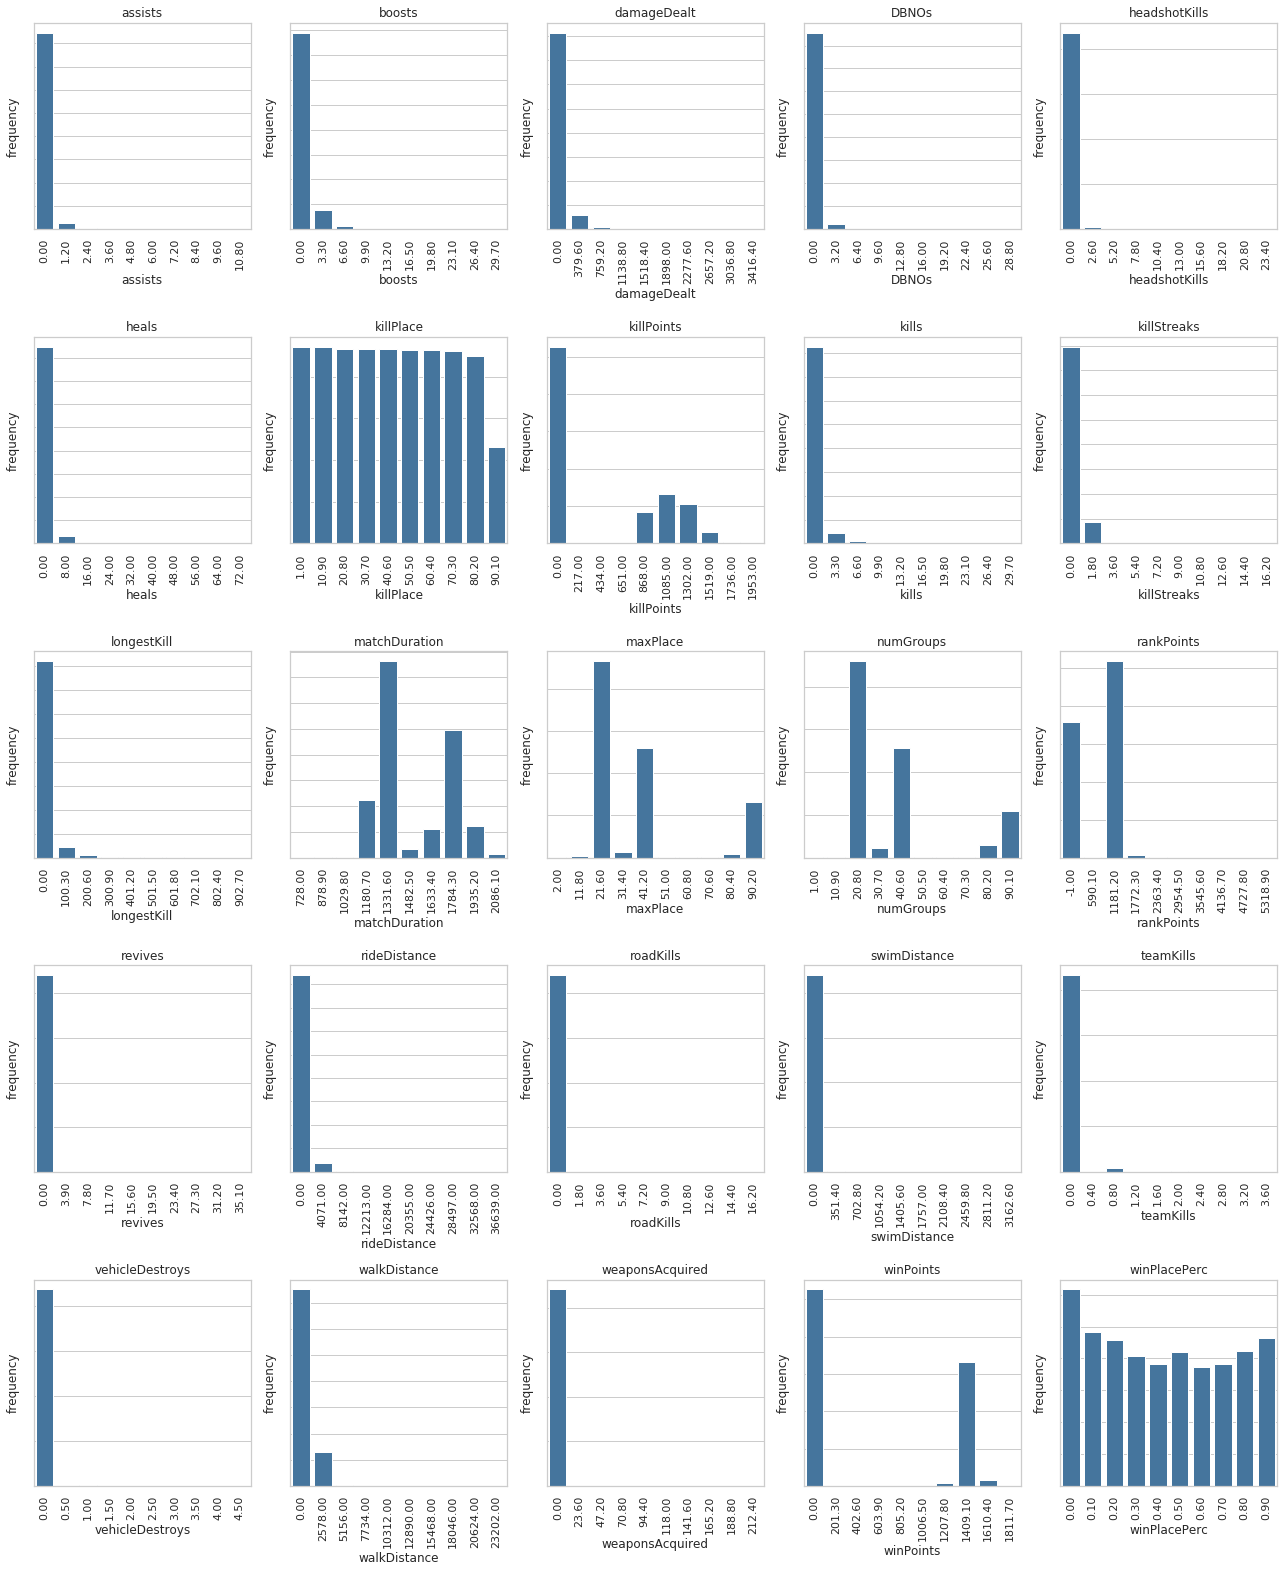

In [111]:
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(5,5,figsize=(18,22))

for col in tqdm(numerical_columns):
    i += 1
    plt.subplot(5,5,i)
    rdd = spark.sql(f'SELECT {col} FROM pubg').rdd.map(lambda x: x[0])
    l = rdd.histogram(10)
    df = pd.DataFrame(list(zip(*l)), columns=[col, 'frequency'])
    df[col] = df[col].apply(lambda x: f'{x:.2f}')
    
    # display
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x = col, y = 'frequency', data = df, color='#3776ab')
    ax.yaxis.set_ticklabels([])
    #ax.set(xlabel=col, ylabel='frequency')
    ax.tick_params(axis='x', rotation=90)
    plt.title(col)
    
fig.tight_layout()
plt.show()
fig.savefig('plot.pdf', bbox_inches='tight')

In [30]:
#sample del dataframe spark per plotting
seed = 42
withReplacement=False
df_pandas = data.sample(withReplacement, 0.1, seed).toPandas()

df_pandas.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchtype', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'winPlaceClass',
       'isFirstPerson'],
      dtype='object')

In [31]:
df_pandas.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,winPlaceClass,isFirstPerson
0,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,0.0,0,0,1089.0,6,1500,0.7368,3,True
1,62f2f0917d84b2,f61b698274d9f5,1d6cfe0f6f23b0,0,2,81.710,1,0,14,25,...,0,0.0,0,0,3674.0,7,0,0.7308,3,True
2,7bd224781f064b,6dde607d151819,733af30cc00099,0,0,0.000,0,0,0,79,...,0,0.0,0,0,137.4,2,0,0.1923,5,True
3,c67405a29d8d94,a4b7f81ca549ad,217c39c4c3835a,0,0,35.870,0,0,1,63,...,0,0.0,0,0,2037.0,4,0,0.5000,4,True
4,a02d62f153b033,69745bfb9412d9,6945783270e8dc,1,1,133.100,1,0,1,47,...,0,0.0,0,0,127.7,1,1454,0.1111,5,True


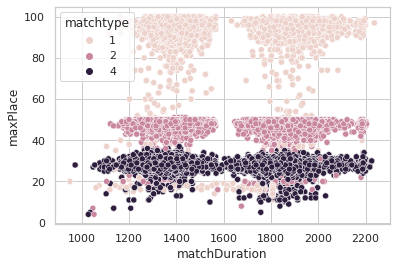

In [32]:
sns.scatterplot(data=df_pandas, x="matchDuration", y="maxPlace", hue="matchtype")

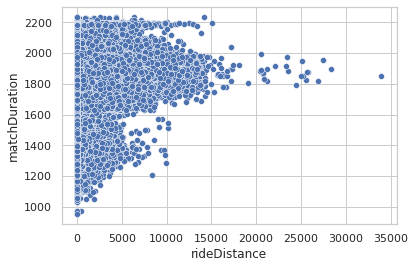

In [34]:
sns.scatterplot(data=df_pandas, x="rideDistance", y="matchDuration")

dallo scatter plot si può intuire che i dati provengano da partite giocate in 2 mappe (o gruppi di mappe) differenti

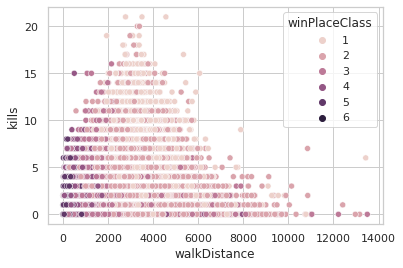

In [35]:
sns.scatterplot(data=df_pandas, x="walkDistance", y="kills", hue="winPlaceClass")

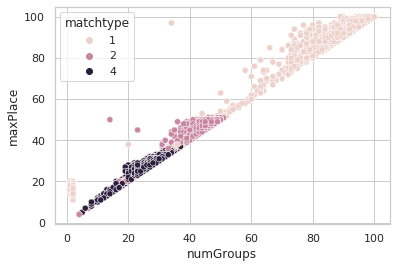

In [36]:
sns.scatterplot(data=df_pandas, x="numGroups", y="maxPlace", hue="matchtype")

---------------------

# Esportazione del dataset (per la classificazione)
### Descrizione query
Oss: con somma dei risultati i player risultanti avrebbero alcuni attributi con domanio diverso e dipendente dal tipo di match, forse è meglio fare la media

Attributi per l'aggregazione. Rimangono invariati per ogni gruppo:
- groupId: nuova chiave
- matchId (dipendende funzionalmente dal gruppo)
- matchDuration
- winPlacePerc
- winPlaceClass
- isFirstPerson
- matchtype
- maxPlace
- numGroups

Funzioni di aggragazione: somma, int(media) e massimo:
- assists: nel caso di solo possono essere anche != da 0, quindi possiamo fare sei la somma che int(media)
- boosts
- heals
- kills
- headshotKills
- killStreaks
- roadKills
- longestKill
- vehicleDestroys
- weaponsAcquired
- damageDealt
- distance
- rideDistance
- swimDistance
- walkDistance
- DBNOs
- revives
- teamKills

solo max:
- killPlace: viene calcolato per ogni giocatore anche in caso di gruppi e riconnessioni.
- rankPoints: sono diversi sempre, anche in caso di gruppi e riconnessioni
- killPoints: nei 2 match che ho preso i valori sono sempre 0
- winPoints: anche questi sono sempre a 0 nei due match analizzati

In [17]:
res = sqlCtx.sql("""SELECT 
                        groupId, matchId, matchDuration, winPlaceClass, isFirstPerson, matchtype, maxPlace, numGroups,
                        
                        IF(COUNT(*) > matchtype, 1, 0) as hasDisconnected,
                        
                        SUM(assists) AS assist_SUM,
                        MAX(assists) AS assist_MAX,
                        IF(COUNT(*) > matchtype, INT(SUM(assists)/matchtype), INT(SUM(assists)/COUNT(*))) as assist_AVG,
                            
                        SUM(heals) AS heals_SUM, 
                        MAX(heals) AS heals_MAX,
                        INT(IF(COUNT(*) > matchtype, SUM(heals)/matchtype, SUM(heals)/COUNT(*))) as heals_AVG,
                            
                        SUM(kills) AS kills_SUM, 
                        MAX(kills) AS kills_MAX,
                        INT(IF(COUNT(*) > matchtype, SUM(kills)/matchtype, SUM(kills)/COUNT(*))) as kills_AVG,
                            
                        SUM(headshotKills) AS headshotKills_SUM, 
                        MAX(headshotKills) AS headshotKills_MAX, 
                        INT(IF(COUNT(*) > matchtype, SUM(headshotKills)/matchtype, SUM(headshotKills)/COUNT(*))) as headshotKills_AVG,
                            
                        MAX(killStreaks) AS killStreaks_MAX,
                        
                        SUM(roadKills) AS roadKills_SUM, 
                        MAX(roadKills) AS roadKills_MAX,
                        INT(IF(COUNT(*) > matchtype, SUM(roadKills)/matchtype, SUM(roadKills)/COUNT(*))) as roadKills_AVG,
                            
                        MAX(longestKill) as longestKill_MAX,
                            
                        MAX(vehicleDestroys) AS vehicleDestroys_MAX, 
                            
                        SUM(weaponsAcquired) AS weaponsAcquired_SUM, 
                        MAX(weaponsAcquired) AS weaponsAcquired_MAX,
                        INT(IF(COUNT(*) > matchtype, SUM(weaponsAcquired)/matchtype, SUM(weaponsAcquired)/COUNT(*))) as weaponsAcquired_AVG,
                            
                        SUM(damageDealt) AS damageDealt_SUM, 
                        MAX(damageDealt) AS damageDealt_MAX,
                        IF(COUNT(*) > matchtype, SUM(damageDealt)/matchtype, SUM(damageDealt)/COUNT(*)) as damageDealt_AVG,
                        
                        SUM(distance) AS distance_SUM, 
                        MAX(distance) AS distance_MAX, 
                        IF(COUNT(*) > matchtype, SUM(distance)/matchtype, SUM(distance)/COUNT(*)) as distance_AVG,
                        
                        SUM(rideDistance) AS rideDistance_SUM, 
                        MAX(rideDistance) AS rideDistance_MAX,
                        IF(COUNT(*) > matchtype, SUM(rideDistance)/matchtype, SUM(rideDistance)/COUNT(*)) as rideDistance_AVG,
                        
                        SUM(swimDistance) AS swimDistance_SUM, 
                        MAX(swimDistance) AS swimDistance_MAX,
                        IF(COUNT(*) > matchtype, SUM(swimDistance)/matchtype, SUM(swimDistance)/COUNT(*)) as swimDistance_AVG,
                        
                        SUM(walkDistance) AS walkDistance_SUM,
                        MAX(walkDistance) AS walkDistance_MAX,
                        IF(COUNT(*) > matchtype, SUM(walkDistance)/matchtype, SUM(walkDistance)/COUNT(*)) as walkDistance_AVG,
                        
                        SUM(DBNOs) AS DBNOs_SUM,
                        MAX(DBNOs) AS DBNOs_MAX,
                        IF(COUNT(*) > matchtype, INT(SUM(DBNOs)/matchtype), INT(SUM(DBNOs)/COUNT(*))) as DBNOs_AVG,
                        
                        SUM(revives) AS revives_SUM,
                        MAX(revives) AS revives_MAX,
                        IF(COUNT(*) > matchtype, INT(SUM(revives)/matchtype), INT(SUM(revives)/COUNT(*))) as revives_AVG,
                        
                        SUM(teamKills) AS teamKills_SUM,
                        MAX(teamKills) AS teamKills_MAX,
                        IF(COUNT(*) > matchtype, INT(SUM(teamKills)/matchtype), INT(SUM(teamKills)/COUNT(*))) as teamKills_AVG,

                        MAX(killPlace) AS killPlace_MAX,
                        MAX(rankPoints) AS rankPoints_MAX,
                        MAX(killPoints) AS killPoints_MAX,
                        MAX(winPoints) AS winPoints_MAX
                         
                         
                    from pubg 
                    group by groupId, matchId, matchDuration, winPlaceClass, isFirstPerson, matchtype, maxPlace, numGroups
                    """)

res.show(10)

+--------------+--------------+-------------+-------------+-------------+---------+--------+---------+---------------+----------+----------+----------+---------+---------+---------+---------+---------+---------+-----------------+-----------------+-----------------+---------------+-------------+-------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+------------------+---------------+------------------+------------------+------------------+------------------+----------------+----------------+-----------------+----------------+----------------+------------------+------------------+----------------+------------------+---------+---------+---------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+
|       groupId|       matchId|matchDuration|winPlaceClass|isFirstPerson|matchtype|maxPlace|numGroups|hasDisconnected|assist_SUM|assist_MAX|ass

In [ ]:
#esporta il dataset "aggregato" per la classificazione
df = res
df.repartition(1).write.option("header",True).option("compression","gzip").csv("tmp")
!cp tmp/*.csv.gz GROUP2.csv.gz
!rm -rf tmp/